In [1]:
using LowRankModels
using PyPlot
using CSV
using DataFrames
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using JLD2
using UMAP
using Test
using PyCall
adjustText = pyimport("adjustText")
seaborn = pyimport("seaborn")
using ScikitLearn.CrossValidation: KFold
using Distributions
#using Logging
using Random
Random.seed!(1408);

n_simulations = 1;
random_seeds = abs.(rand(Int, n_simulations));
#ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40]; # ranks
ks = collect(1:6); # ranks
γs = 10.0 .^ range(-1.0, 3.0, length=5); # regularization params
#target_sparsities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9];
target_sparsities = [0.9];

In /home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/

# Load Henry coefficient matrix `H`

see `CreateMatrix.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

* the values of the Henry coefficients were `log10`-transformed

In [2]:
## filename = "logH_matrix_materials_and_gases_interp.jld2"
#filename = "logH_matrix_materials_and_gases_lang.jld2"
#@load joinpath("data", filename) H master_list_of_materials master_list_of_gases MSE
#materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
#gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H
#
#nm, ng = size(H) #no. of materials and gases
#@show nm
#@show ng
#@assert nm == length(materials)
#@assert ng == length(gases)
#
#@assert length(materials) == nm && length(gases) == ng

In [3]:
cif_files = DataFrame!(CSV.File("cof-frameworks.csv"))
cif_file_dict = Dict([cif_files[!, Symbol("CURATED-COFs ID")][i] => cif_files[!, Symbol("Name")][i] for i = 1:size(cif_files)[1]])

Dict{String,String} with 626 entries:
  "19361N2" => "TT TAPB-COF"
  "16121N2" => "TpPa-SO3H-Py"
  "20330N2" => "TAPB-PDA"
  "18122N3" => "3D-IL-COF-3"
  "17131N2" => "TP-COF-DAB"
  "19420N3" => "PCOF-1"
  "19412N2" => "Per-Py COF"
  "19191N2" => "CCOF-8"
  "19370N2" => "Aminal-COF-2"
  "16271N2" => "4PE-2P"
  "20112N3" => "JUC-550 3-fold"
  "19352N2" => "BFBAEPy-COF"
  "19440N2" => "CuPc-pz"
  "20111N3" => "JUC-550 2-fold"
  "17061N2" => "HAT-NTBA-COF"
  "16054N2" => "MC-COF-TP-E12E21"
  "05000N2" => "COF-1"
  "20540N2" => "QTD-COF-1"
  "20391N2" => "Py-FTP-BT-COF"
  "16160N2" => "IISERP-COF3"
  "10001N2" => "CTF-2 AB"
  "17160N3" => "3D-CuPor-COF-0P"
  "13190N2" => "CTV-COF-1"
  "12060N2" => "ZnPc-COF"
  "16080N2" => "BW-COF AA"
  ⋮         => ⋮

In [4]:
og_df = DataFrame!(CSV.File("aiida_ads_data_oct20.csv"));
#og_df = DataFrame!(CSV.File("appl_aiida_data.csv"));

In [5]:
data_df = og_df[:, [typeof(og_df[:,i]) == Array{Float64, 1} for i in 1:size(og_df)[2]]] # Remove columns that contain units

,o2_1bar,o2_5bar,o2_10bar,o2_20bar,o2_30bar,o2_50bar,o2_80bar,o2_100bar
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.491582,1.96734,3.57136,6.00329,8.15379,11.3615,14.9515,16.8415
2,0.276674,1.29231,2.42996,4.42071,6.02502,8.73799,11.8508,13.4834
3,0.130522,0.615209,1.12739,1.99016,2.66359,3.71188,4.82799,5.37879
4,0.311026,1.44014,2.76731,4.99491,6.83599,9.82212,13.1439,14.8106
5,0.516942,2.51701,4.86765,9.18074,12.8908,18.8453,25.061,27.7641
6,0.315747,1.50428,2.84338,5.27919,7.69913,11.661,16.7131,19.4849
7,0.218389,1.04152,2.02252,3.80523,5.37101,7.96477,10.9106,12.465
8,0.389942,1.71874,3.05865,5.27598,7.00536,10.0604,13.3468,15.0891
9,0.315039,1.46325,2.69137,4.74882,6.51561,9.48594,12.6523,14.3563


In [6]:
title_dict = Dict("o2_5bar" => L"O$_2$" * @sprintf("\nat 298K, 5 bar"), "o2_140bar" => L"O$_2$" * @sprintf("\nat 298K, 140 bar"), "co2_0.001bar" => L"CO$_2$" * @sprintf("\nat 300K, 0.001 bar"), 
                  "co2_30bar" => L"CO$_2$" * @sprintf("\nat 300K, 30 bar"), "n2_0.001bar" => L"N$_2$" * @sprintf("\nat 300K, 0.001 bar"), 
                  "n2_30bar" => L"N$_2$" * @sprintf("\nat 300K, 30 bar"), "h2_77K_5bar" => L"H$_2$" * @sprintf("\nat 77K, 5 bar"), 
                  "h2_77K_100bar" => L"H$_2$" * @sprintf("\nat 77K, 100 bar"), "h2_298K_5bar" => L"H$_2$" * @sprintf("\nat 298K, 5 bar"), 
                  "h2_298K_100bar" => L"H$_2$" * @sprintf("\nat 298K, 100 bar"), "h2o_henry" => L"H$_2$O" * @sprintf("\nHenry Coeff at 300K"), 
                  "h2s_henry" => L"H$_2$S" * @sprintf("\nHenry Coeff at 300K"), "xe_henry" => @sprintf("Xe\n Henry Coeff at 300K"), 
                  "kr_henry" => @sprintf("Kr\n Henry Coeff at 300K"), "ch4_65bar" => L"CH$_4$" * @sprintf("\n at 298K, 65 bar"), "ch4_5.8bar" => L"CH$_4$" * @sprintf("\n at 298K, 5.8 bar"),
                  "largest_free_sphere" => "Largest Free Sphere [Ang]", "largest_included_sphere" => "Largest Included Sphere [Ang]",
                  "largest_included_free_sphere" => "Largest Included Free Sphere [Ang]", "AV_volume_fraction" => "Void Fraction",
                  "ASA_m^2/cm^3" => @sprintf("Available Surface\nArea ") * L"[m$^2$/cm$^3$]")


Dict{String,String} with 21 entries:
  "largest_included_free_sphere" => "Largest Included Free Sphere [Ang]"
  "h2_298K_100bar"               => "H\$_2\$\nat 298K, 100 bar"
  "o2_5bar"                      => "O\$_2\$\nat 298K, 5 bar"
  "kr_henry"                     => "Kr\n Henry Coeff at 300K"
  "n2_30bar"                     => "N\$_2\$\nat 300K, 30 bar"
  "n2_0.001bar"                  => "N\$_2\$\nat 300K, 0.001 bar"
  "ch4_65bar"                    => "CH\$_4\$\n at 298K, 65 bar"
  "xe_henry"                     => "Xe\n Henry Coeff at 300K"
  "ch4_5.8bar"                   => "CH\$_4\$\n at 298K, 5.8 bar"
  "co2_0.001bar"                 => "CO\$_2\$\nat 300K, 0.001 bar"
  "AV_volume_fraction"           => "Void Fraction"
  "h2_77K_5bar"                  => "H\$_2\$\nat 77K, 5 bar"
  "largest_included_sphere"      => "Largest Included Sphere [Ang]"
  "ASA_m^2/cm^3"                 => "Available Surface\nArea [m\$^2\$/cm\$^3\$]"
  "co2_30bar"                    => "CO\$_2\$\nat

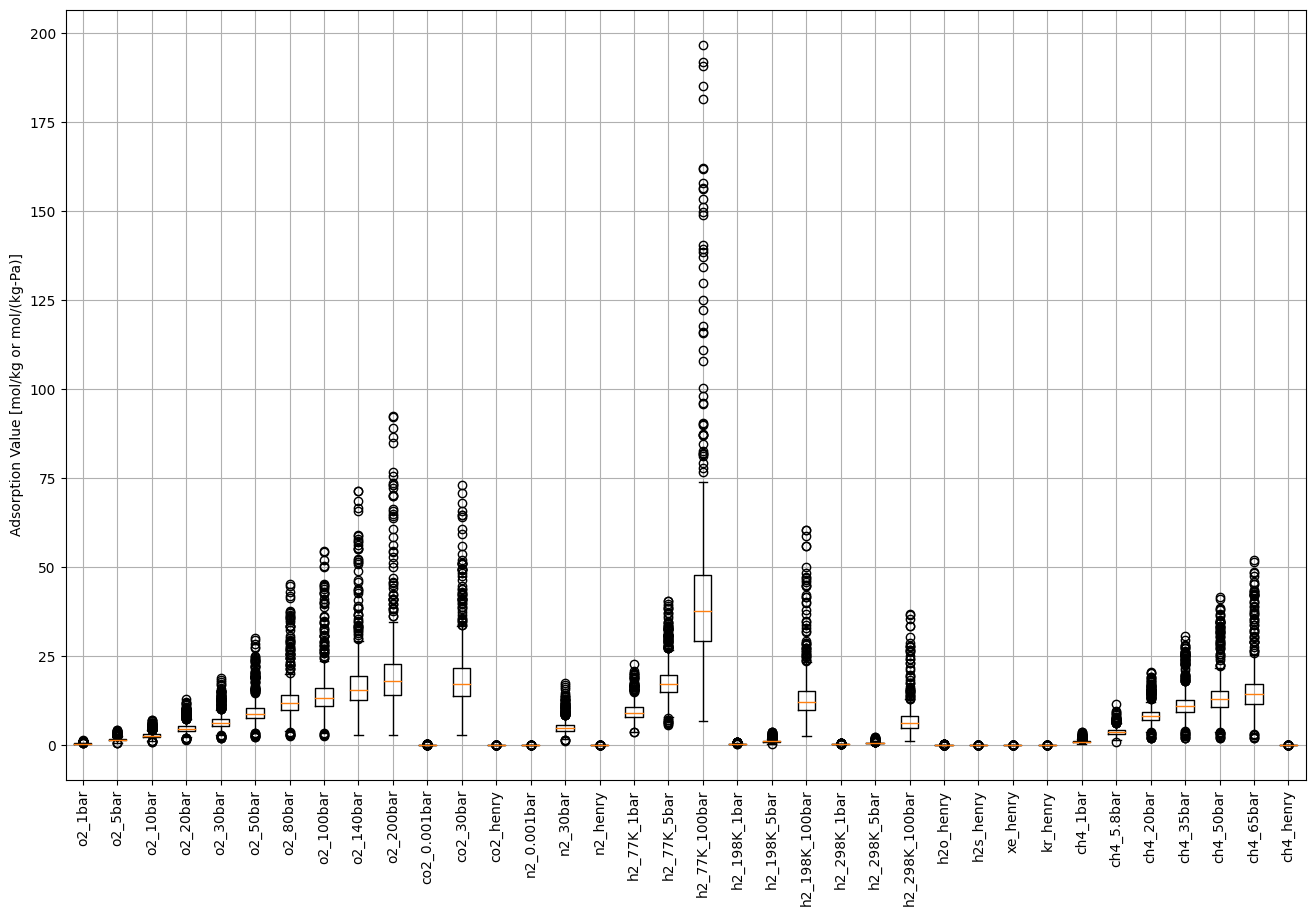

In [7]:
fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(convert(Matrix, data_df))
ax.set_xticklabels(names(data_df), rotation=90)
ax.set_ylabel("Adsorption Value [mol/kg or mol/(kg-Pa)]")
ax.grid("on")
plt.savefig("appl_aiida_data.png", dpi=300, format="png")

In [8]:
curated_df = og_df[!, Symbol.(["o2_5bar", "o2_140bar", "co2_0.001bar", "co2_30bar", "n2_0.001bar", "n2_30bar", 
                       "h2_77K_5bar", "h2_77K_100bar", "h2_298K_5bar", "h2_298K_100bar", "h2o_henry", "h2s_henry",
                       "xe_henry", "kr_henry", "ch4_65bar", "ch4_5.8bar"])]
curated_df[!, Symbol("h2o_henry")] = log10.(1e5 .* curated_df[!, Symbol("h2o_henry")]) # Converting units from mol/(kg-Pa) to mol/(kg-bar)
curated_df[!, Symbol("h2s_henry")] = log10.(1e5 .* curated_df[!, Symbol("h2s_henry")]) #   1 Pa = 1e-5 bar 
curated_df[!, Symbol("xe_henry")] = log10.(1e5 .* curated_df[!, Symbol("xe_henry")])   #   Then taking the log10 of the Henry Coeffs to spread
curated_df[!, Symbol("kr_henry")] = log10.(1e5 .* curated_df[!, Symbol("kr_henry")])   #   their range more, so they won't group up around 0
#curated_df = deepcopy(data_df)
#curated_df[!, Symbol("h2sh2osel_300K")] = log10.(curated_df[!, Symbol("h2sh2osel_300K")])
#curated_df[!, Symbol("xekrsel_300K")] = log10.(curated_df[!, Symbol("xekrsel_300K")])   
gases = names(curated_df)
materials = og_df[!, :cof]
global global_ng = length(gases)
global global_nm = length(materials)
const curated_matrix = convert(Matrix, curated_df)

560×16 Array{Float64,2}:
 1.96734   19.9122   0.0124334    28.0097   …   0.297723   17.5471   4.21505
 1.29231   16.1392   0.00109779   15.141       -0.048011   14.6378   3.42005
 0.615209   6.19292  0.00172039    7.81048     -0.29355     5.86365  1.6706
 1.44014   17.7006   0.00251566   21.7474      -0.0221681  15.6315   3.83379
 2.51701   31.9531   0.00248128   41.3255       0.0979199  29.9933   6.62541
 1.50428   24.3578   0.000683359  19.107    …  -0.130649   19.9647   3.27402
 1.04152   14.9188   0.00117168   21.4304      -0.236576   13.9739   2.74787
 1.71874   17.7802   0.00905058   27.4898       0.114694   15.9039   3.67995
 1.46325   17.0192   0.00103828   17.6792       0.0296516  15.9355   3.75415
 1.39049   14.3621   0.00288507   19.5152       0.0317517  13.0936   3.84831
 1.45882   18.7661   0.00132216   23.6472   …  -0.0488     16.5404   3.66813
 1.29248   12.2972   0.000886952  13.6414      -0.0181841  11.8801   3.89781
 1.33243   17.9757   0.00107295   25.3712      -0.09

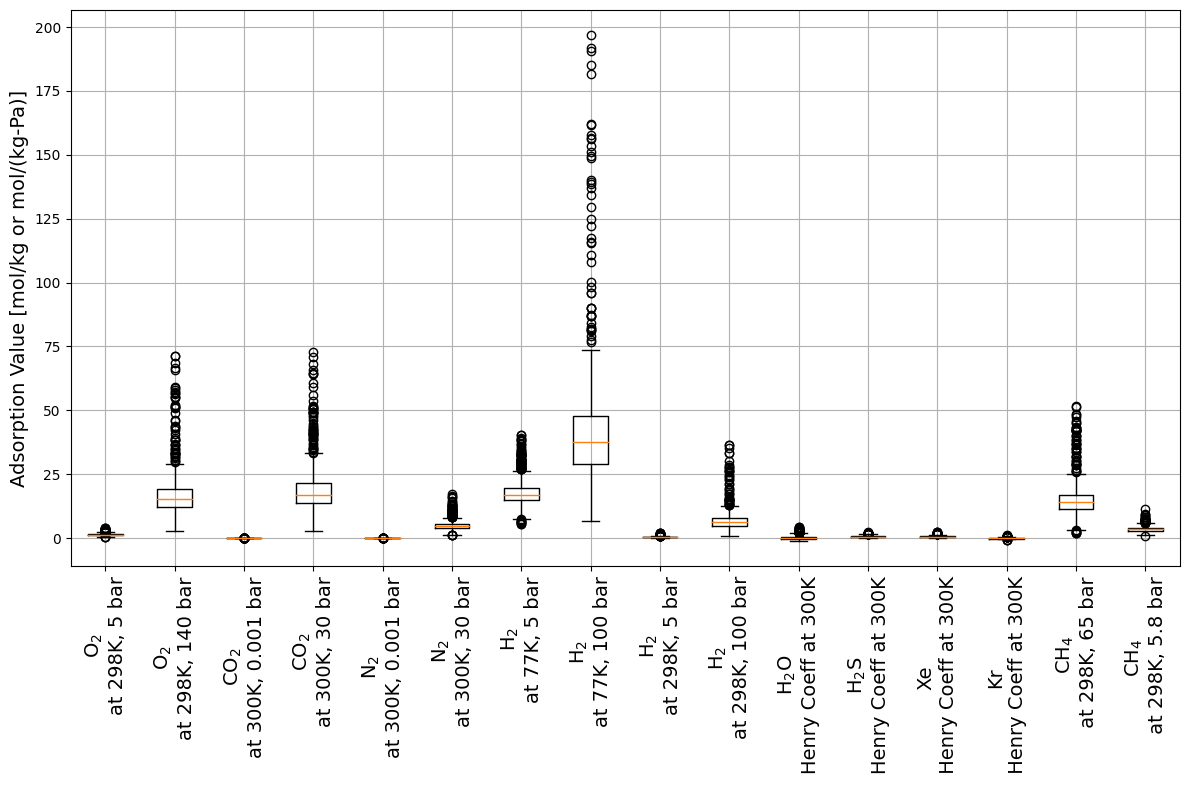

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(curated_matrix)
ax.set_xticklabels([title_dict[gas] for gas in gases], rotation=90, size=14)
ax.set_ylabel("Adsorption Value [mol/kg or mol/(kg-Pa)]", size=14)
ax.grid("on")
plt.tight_layout()
plt.savefig("aiida_curated_data.png", dpi=300, format="png")

In [10]:
#curated_df = og_df[!, Symbol.(["o2_5bar", "o2_140bar", "co2_0.001bar", "co2_30bar", "n2_0.001bar", "n2_30bar", 
#                       "h2_77K_5bar", "h2_77K_100bar", "h2_298K_5bar", "h2_298K_100bar", "ch4_65bar", "ch4_5.8bar"])]
#gases = names(curated_df)
#materials = og_df[!, :cof]
#curated_matrix = convert(Matrix, curated_df)

In [11]:
function create_sparse_matrix_bernoulli(og_df_matrix::Array{Float64, 2}, target_sparsity::Float64; seed::Int=abs(rand(Int)))
    Random.seed!(seed)
    bernoulli_dist = Bernoulli(target_sparsity)
    sparse_matrix = convert(Array{Union{Float64, Missing}, 2}, deepcopy(og_df_matrix))
    is_missing = rand(bernoulli_dist, size(og_df_matrix))
    sparse_matrix[is_missing] .= missing
    return sparse_matrix, sum(is_missing)/length(is_missing)
end

sparse_matrix, sparsity = create_sparse_matrix_bernoulli(curated_matrix, 0.8)
@assert (create_sparse_matrix_bernoulli(curated_matrix, 0.8, seed=1408)[2]) == (create_sparse_matrix_bernoulli(curated_matrix, 0.8, seed=1408)[2])
sparsity

0.8035714285714286

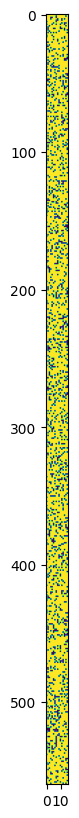

PyObject <matplotlib.image.AxesImage object at 0x7f79c2487358>

In [12]:
fig, ax = plt.subplots(figsize=(40,10))
missing_obs = ismissing.(sparse_matrix)
sparse_matrix[missing_obs] .= 1000
ax.imshow(sparse_matrix)

In [13]:
sum([sum(1 .- ismissing.(sparse_matrix[i,:])) for i = 1:size(sparse_matrix)[1]] .== 0)

0

In [14]:
function create_sparse_matrix_random(og_df_matrix::Array{Float64, 2}, target_sparsity::Float64)
    sparse_matrix = convert(Array{Union{Float64, Missing}, 2}, deepcopy(og_df_matrix))
    nm, ng = size(sparse_matrix)
    sparsity = 0.0
    N = length(sparse_matrix)
    while sparsity < target_sparsity
        m = rand(1:nm)
        g = rand(1:ng)
        sparse_matrix[m,g] = missing
        sparsity = sum(ismissing.(sparse_matrix))/N
    end
    return sparse_matrix, sparsity
end
sparse_matrix, sparsity = create_sparse_matrix_random(curated_matrix, 0.8)
sparsity

0.8

In [15]:
sum([sum(1 .- ismissing.(sparse_matrix[i,:])) for i = 1:size(sparse_matrix)[1]] .== 0)

14

## standardize columns
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [16]:
function standardize_cols!(sparse_matrix)
    nm, ng = size(sparse_matrix)
    means = Array{Float64, 1}(undef, ng)
    stds = Array{Float64, 1}(undef, ng)
    # standardize the columns
    for j = 1:ng
        # find ids that are not missing
        ids = .! ismissing.(sparse_matrix[:, j])
        means[j] = mean(sparse_matrix[ids, j])
        stds[j] = std(sparse_matrix[ids, j])
        sparse_matrix[:, j] .= (sparse_matrix[:, j] .- means[j]) ./ stds[j]
    end
    return means, stds
end

#means, stds = standardize_cols!(H)

standardize_cols! (generic function with 1 method)

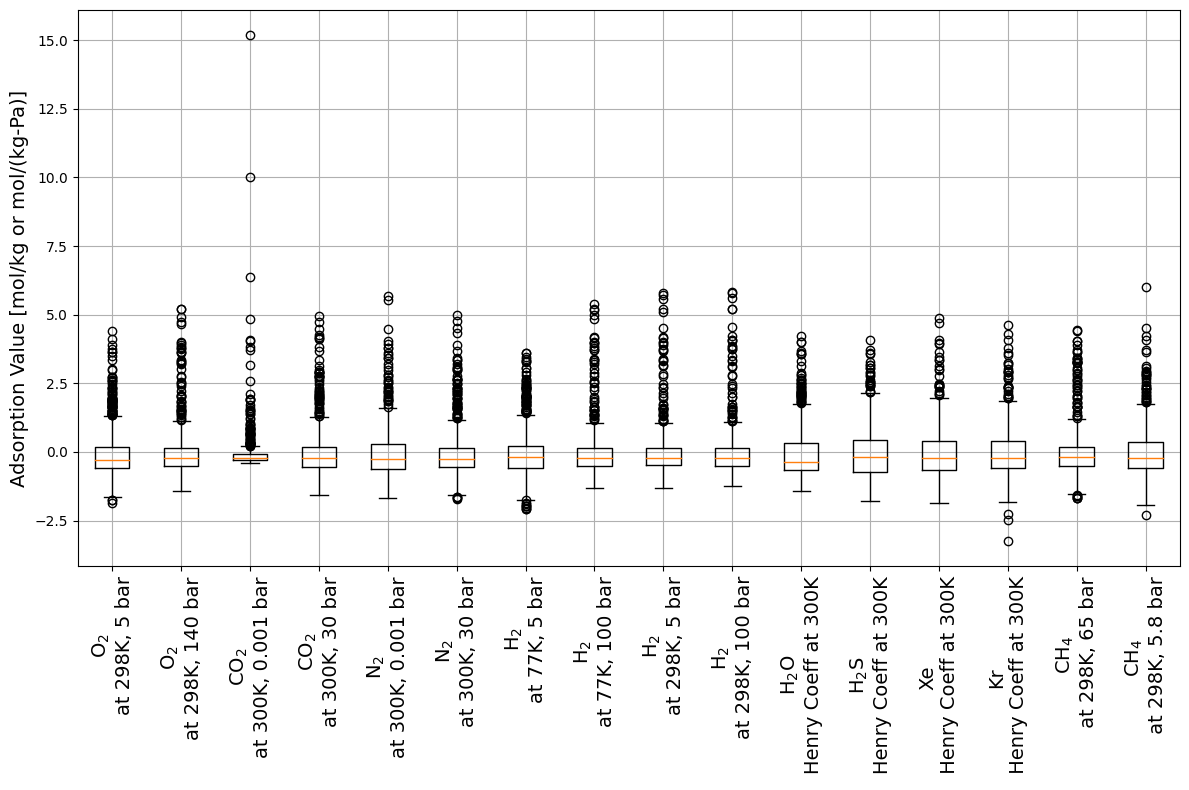

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
A = deepcopy(curated_matrix)
standardize_cols!(A)
ax.boxplot(A)
ax.set_xticklabels([title_dict[gas] for gas in gases], rotation=90, size=14)
ax.set_ylabel("Adsorption Value [mol/kg or mol/(kg-Pa)]", size=14)
ax.grid("on")
plt.tight_layout()
plt.savefig("aiida_standardized_curated_data.png", dpi=300, format="png")

### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [18]:
# k = rank of matrix
# γ = regularization param
# obs = which observations we train on.
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(sparse_matrix, k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64}, 1}; verbose::Bool=true)
    ng, nm = size(sparse_matrix)
    rg = QuadReg(γ) # quadratic regularizer on gas matrix G
    rm = QuadReg(γ * ng / nm) # quadratic regularizer on MOF matrix M
    @assert (ng, nm) == (global_ng, global_nm) @sprintf("(%d, %d) == (%d, %d)", ng, nm, global_ng, global_nm)

    glrm = GLRM(sparse_matrix, QuadLoss(), rg, rm, k, obs=obs, offset=true)
#    init_svd!(glrm)
    G, M, ch = fit!(glrm, verbose=verbose) # H' ~ G' * M well, our mathy H
    @assert size(G)[2] == ng
    @assert size(M)[2] == nm

    @assert isapprox(impute(glrm), G' * M)
    return G, M, glrm, ch
end

new_sparse_matrix = collect(sparse_matrix')
ids_obs = observations(new_sparse_matrix) # returns tuple of observations
G, M, glrm, ch = fit_glrm(new_sparse_matrix, 2, 1.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 86420.25620512752
Iteration 20: objective value = 71827.59787273008
Iteration 30: objective value = 68063.66806274165
Iteration 40: objective value = 66328.07401001987
Iteration 50: objective value = 65036.061323846756
Iteration 60: objective value = 63983.636250590636
Iteration 70: objective value = 63185.88540860307


([1.0472253272989411 0.21064432252962587 … -0.05334021532253651 1.010368413720453; 1.0 1.0 … 1.0 1.0], [-12.732593516861135 -0.6702491840153266 … -58.555276764037785 -0.0156433231544661; 15.265958390824444 8.330663743870097 … 53.98139623264968 1.0544111556138969], GLRM(Union{Missing, Float64}[missing missing … missing missing; missing missing … 50.795901594684 missing; … ; 17.547083302337 14.637840045125 … missing missing; 4.2150522857816 missing … 4.2479617102314 missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDo

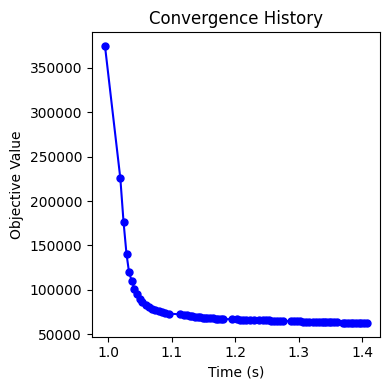

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ch.times, ch.objective, color="b", marker="o", markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective Value")
ax.set_title("Convergence History")
plt.tight_layout()
plt.show()

## functions to evaluate Spearmann-rank correlation, stratified among gas

In [20]:
"""
return indices of observations in H that involve gas g only.
"""
function ids_obs_gas(ids_obs::Array{Tuple{Int, Int}, 1}, g::Int)
    ids_obs_g = Tuple{Int64, Int64}[]
    for id_obs in ids_obs
        # if gas g is involved in this observation, push it
        if g == id_obs[1] # remember: H is transposed here.
            push!(ids_obs_g, id_obs)
        end
    end
    return ids_obs_g
end

"""
compute the spearmann rank correlation coeff between observations and predictions, 
     under constraint that these observations correspond to gas g.
     also return the number of observations with this gas.
"""
function ρ_g(H::Array{Union{Float64, Missing}, 2}, Ĥ::Array{<:Number, 2}, 
             g::Int, ids_obs::Array{Tuple{Int, Int}, 1})
    # find all observations belonging to gas g
    ids_obs_g = ids_obs_gas(ids_obs, g)
    nb_obs_gas_g = length(ids_obs_g) # number of observations with this gas
    
    # construct arrays of truth/prediction of H for this gas
    H_g = [H[i, j] for (i, j) in ids_obs_g] # truth
    Ĥ_g = [Ĥ[i, j] for (i, j) in ids_obs_g] # prediction
    
    if nb_obs_gas_g in [0, 1]
        #println("only zero or one obs, can't compute spearmann rank")
        return nb_obs_gas_g, 0.0
    end
    
    ρg = corspearman(H_g, Ĥ_g) # Spearmann rank correlation coefficient
    if isnan(ρg)
        #error("ρg == NaN ...")
        return nb_obs_gas_g, 0.0
    end
    return nb_obs_gas_g, ρg 
end

"""
if ρᵧ is Spearmann rank corr. coeff. for gas γ, then this function returns average ρᵧ, weighted by
    the number of observations for that gas.
"""
function ρ_wt_avg(H::Array{Union{Float64, Missing}, 2}, Ĥ::Array{<:Number, 2}, ids_obs::Array{Tuple{Int, Int}, 1})
    ng, nm = size(H)
    @assert nm > ng && ng == global_ng
    ρ = 0.0
    total_nb_obs = 0
    @assert ng == global_ng
    for g = 1:ng
        nb_obs_gas_g, ρg = ρ_g(H, Ĥ, g, ids_obs)
        ρ += ρg * nb_obs_gas_g
        total_nb_obs += nb_obs_gas_g
    end
    @assert total_nb_obs == length(ids_obs)    
    return ρ / total_nb_obs
end

ρ_wt_avg

In [21]:
function spearman_plot(avg_ρ_gs::Array{Float64, 1}, std_ρ_gs::Array{Float64, 1}, avg_ρ_gs_simple::Array{Float64, 1}, std_ρ_gs_simple::Array{Float64, 1},
                       target_sparsity::Float64)
    fig, ax = plt.subplots(figsize=(12,6))
    colors = seaborn.color_palette("tab20", length(gases)) # 10 unique "evenly spaced" colors

    brs = ax.bar(1:global_ng, avg_ρ_gs, linewidth=2.0, fc="#e6beff", ec="k", alpha=0.9, label="Optimal Models")
    #for (i, ρ_g_i) in enumerate(avg_ρ_gs)
    #    ax.text(i, abs(ρ_g_i)+0.02, @sprintf("%.2f\n +/-\n %.2f", ρ_g_i, std_ρ_gs[i]), ha="center", fontsize=8)
    #end
    xlim = ax.get_xlim()
    ax.plot(xlim, [0, 0], c="k", alpha=0.7, zorder=5.5, lw=2.5)
    #ax.set_title(@sprintf("Percentage missing: %d%%", Int(100*target_sparsity)))
    ax.set_xlim(xlim)
    ax.set_xticks(1:global_ng)
    ax.set_ylim([-0.35, 1.15])
    ax.set_yticks([-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.grid(which="major", lw=3)
    ax.yaxis.grid(which="minor", lw=1)
    ax.set_axisbelow(true)

    xticklabels = [title_dict[n] for n in names(curated_df)]
#    xticklabels = [n for n in names(curated_df)]
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=16)
    ax.set_ylabel(@sprintf("Spearman Rank\nCorrelation Coefficient\n")  * L"$\rho$", fontsize=20)
    #    ax.scatter(1:length(avg_ρ_gs_simplistic), avg_ρ_gs_simplistic, marker="*", s=82, 
    #               fc="#aaffc3", ec="k", alpha=0.7, label="k = 1 model", zorder=99)
    ax.errorbar(1:length(avg_ρ_gs_simple), avg_ρ_gs_simple, yerr=std_ρ_gs_simple, marker="*", ms=8, 
               mfc="#aaffc3", mec="k", alpha=0.7, label="Material Offset model", zorder=99, ls="none", capsize=5.0, capthick=1.0,
               elinewidth=2.5)
    ax.errorbar(1:length(avg_ρ_gs), avg_ρ_gs, yerr=std_ρ_gs, fmt="none", zorder=99, ls="none", ecolor="#911eb4", 
                capsize=5.0, capthick=1.0, elinewidth=2.5)
    plt.tight_layout()
    ax.legend(prop=Dict("size" => 14))
    #    axhline(y=cv_results[opt_k]["ρ_wt_avg"][i_γ], linestyle="--", zorder=0)
    plt.savefig(@sprintf("test_results_sparsity_%dp.pdf", Int(100*target_sparsity)), dpi=300, format="pdf")
    plt.show()
    return
end

spearman_plot (generic function with 1 method)

In [22]:
function run_simulation(sparse_matrix::Union{Array{Union{Float64, Missing}, 2}, Array{Float64, 2}}, 
                        train_ids_obs::Array{Tuple{Int,Int}, 1},  valid_ids_obs::Array{Tuple{Int,Int}, 1}, 
                        k::Int, γ::Float64, progress_meter::Progress)
    G, M, glrm, ch = fit_glrm(sparse_matrix, k, γ, train_ids_obs, verbose=false)
    Â = impute(glrm) # predictions
    valid_pred = [Â[i,j] for (i,j) in valid_ids_obs]
    valid_true = [sparse_matrix[i,j] for (i,j) in valid_ids_obs]
    ProgressMeter.next!(progress_meter)
    return rmsd(valid_pred, valid_true), ρ_wt_avg(sparse_matrix, Â, valid_ids_obs)
end

run_simulation (generic function with 1 method)

In [23]:
function parity_plot(Â::Array{Float64, 2}, A::Array{Float64, 2}, test_ids_obs::Array{Tuple{Int, Int}, 1}, means::Array{Float64, 1}, stdes::Array{Float64, 1}, 
        target_sparsity::Float64)
    fig, ax1 = plt.subplots(figsize=(8,6))
    
    unstds_Â = deepcopy(Â)
    stds_A = deepcopy(A)
    A = deepcopy(A)
    Â = deepcopy(Â)
    
    @assert size(unstds_Â) == size(curated_matrix')
    @assert size(unstds_Â)[1] == global_ng
    for i = 1:global_ng
        unstds_Â[i, :] .= unstds_Â[i, :] .* stdes[i] .+ means[i]
        stds_A[i, :] .= (stds_A[i, :] .- means[i]) ./ stdes[i]
    end
    
    unstds_Â = [unstds_Â[i,j] for (i,j) in test_ids_obs]
    stds_A = [stds_A[i,j] for (i,j) in test_ids_obs]
    Â = [Â[i,j] for (i,j) in test_ids_obs]
    A = [A[i,j] for (i,j) in test_ids_obs]
    
    #plt.suptitle(@sprintf("Percentage missing: %d%%", Int(100*target_sparsity)))
    # Do this, and scale (standardize) like below
    #    standardized_H[i, :] .= (H[i, :] - mean(sparse_matrix[i, :])) / std(sparse_matrix[i, :])
    #xrange = maximum(unstds_Â[:]) - minimum(unstds_Â[:])
    #yrange = maximum(A[:]) - minimum(A[:])
    #gridsize = (round(Int, xrange/yrange * 20), 20)
#    gridsize = (35,35)
#    hxbin = axs[1].hexbin(unstds_Â[:], A[:], mincnt=1, gridsize=gridsize, bins="log")
    #hxbin = ax1.hexbin(A[:], unstds_Â[:], gridsize=(35,30), mincnt=1, bins=range(min(minimum(A[:]), minimum(unstds_Â[:])), stop=max(maximum(A[:]), maximum(unstds_Â)), length=20))
    hxbin = ax1.hexbin(A[:], unstds_Â[:], mincnt=1, bins=range(min(minimum(A[:]), minimum(unstds_Â[:])), stop=max(maximum(A[:]), maximum(unstds_Â)), length=20))
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    lim = [min(xlim[1], ylim[1]), max(xlim[2], ylim[2])]
    ax1.plot(lim, lim, c="#800000", linewidth=2, zorder=1.5)
    ax1.grid("on")
    ax1.set_axisbelow(true)
    ax1.set_xlim(lim)
    ax1.set_ylim(lim)
    ax1.set_aspect("equal")
    ax1.set_ylabel("Predicted adsorption", fontsize=20)
    ax1.set_xlabel("Actual adsorption", fontsize=20)
    ax1.set_xticklabels(ax1.get_xticks(), fontsize=18)
    ax1.set_yticklabels(ax1.get_yticks(), fontsize=18)
    cbar = plt.colorbar(hxbin, ax=ax1)
    cbar.set_label("Density of points", fontsize=20)
    for t in cbar.ax.get_yticklabels()
        t.set_fontsize(18)
    end
    plt.savefig(@sprintf("test_results_sparsity_%dp_parity1.pdf", Int(100*target_sparsity)), dpi=300, format="pdf")
    plt.show()


    #xrange = maximum(Â[:]) - minimum(Â[:])
    #yrange = maximum(stds_A[:]) - minimum(stds_A[:])
    #gridsize = (round(Int, xrange/yrange * 20), 20)
#    gridsize = (35,35)
#    hxbin = axs[2].hexbin(Â[:], stds_A[:], mincnt=1, gridsize=gridsize, bins="log")
    fig, ax2 = plt.subplots(figsize=(8,6))
#    plt.suptitle(@sprintf("Percentage missing: %d%%", Int(100*target_sparsity)))
    #hxbin = ax2.hexbin(stds_A[:], Â[:], gridsize=(20,20), mincnt=1, bins="log")
    hxbin = ax2.hexbin(stds_A[:], Â[:], mincnt=1, bins=range(min(minimum(stds_A[:]), minimum(Â[:])), stop=max(maximum(stds_A[:]), maximum(Â)), length=20))
    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    lim = [min(xlim[1], ylim[1]), max(xlim[2], ylim[2])]
    ax2.plot(lim, lim, c="#800000", linewidth=2.0, zorder=1.5)
    ax2.grid("on")
    ax2.set_axisbelow(true)
    ax2.set_xlim(lim)
    ax2.set_ylim(lim)
    ax2.set_aspect("equal")
    ax2.set_xlabel("Standardized Actual adsorption", fontsize=20)
    ax2.set_ylabel("Standardized Predicted adsorption", fontsize=20)
    ax2.set_xticklabels(ax2.get_xticks(), fontsize=18)
    ax2.set_yticklabels(ax2.get_yticks(), fontsize=18)
    cbar2 = plt.colorbar(hxbin, ax=ax2)
    cbar2.set_label("Density of points", fontsize=20)
    for t in cbar2.ax.get_yticklabels()
        t.set_fontsize(18)
    end
    plt.savefig(@sprintf("test_results_sparsity_%dp_parity2.pdf", Int(100*target_sparsity)), dpi=300, format="pdf")
    plt.show()
    return
end

parity_plot (generic function with 1 method)

In [24]:
function plot_offset(μ::Array{Float64, 1}, sparsity::Float64, show_all_materials::Bool=false)
    N = length(μ)
    sorted_idx = sortperm(μ)[end:-1:1]
    color = "#469990"
    edgecolor = "k"
    if N > 40 && !show_all_materials
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:19, μ[sorted_idx][1:19], 0.8, linewidth=2.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.bar(21:40, μ[sorted_idx][end-19:end], 0.8, linewidth=2.5, label="Offset", color=color, edgecolor=edgecolor)
        ax.plot([-1, 19.7], [0, 0], c=edgecolor, lw=3.5)
        ax.plot([20.3, 41], [0, 0], c=edgecolor, lw=3.5)
        ax.plot([19.7, 19.9], [0, 0.5], c=edgecolor, lw=3.5)
        ax.plot([19.9, 20.1], [0.5, -0.5], c=edgecolor, lw=3.5)
        ax.plot([20.1, 20.3], [-0.5, 0], c=edgecolor, lw=3.5)
        ax.set_xlim(0, 41)
    else
        fig, ax = plt.subplots(figsize=(20,8))
        ax.bar(1:N, μ[sorted_idx], 0.8, linewidth=1.5, label="Offset", color=color, edgecolor=edgecolor)
        xlim = ax.get_xlim()
        ax.plot(xlim, [0, 0], c=edgecolor, lw=3.5, alpha=0.5)
        ax.set_xlim(0, N)
    end
    
    
    ax.set_ylabel(L"Material offset $\mathbf{\mu}$", fontsize=26)
    xlabels = [cif_file_dict[split(material, ".")[1]] for material in materials[sorted_idx]]
    old_xlabels = [split(material, ".")[1] for material in materials[sorted_idx]]
    if N > 40 && !show_all_materials
        ax.set_xticks(1:40)
        ax.set_xticklabels(vcat(vcat(xlabels[1:19], ["..."]), xlabels[end-19:end]), rotation=90, fontsize=20)
        for tick in ax.get_xticklabels()
            if tick.get_text() == "..."
                tick.set_rotation(0)
                tick.set_fontsize(20)
                tick.set_weight("bold")
            end
        end
    else
        ax.set_xticks(1:length(xlabels))
        ax.set_xticklabels(xlabels, rotation=90, fontsize=22)
    end
    ax.set_yticklabels(ax.get_yticks(), fontsize=20)
    #ax.set_title(mof_or_gas + ' biases from RecSys model', fontsize=16)
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.grid(which="major", lw=3)
    ax.yaxis.grid(which="minor", lw=1.0)
    ax.set_axisbelow(true)
#    ax.set_title(@sprintf("Percentage missing: %d%%", Int(100*sparsity)))
    plt.tight_layout()
    plt.savefig("prelim_offset_sparsity" * string(Int(sparsity*100)) * ".pdf", dpi=300, format="pdf")
    plt.show()
end
#[plot_offset(offsets[i,:], target_sparsities[i], false) for i = 1:length(target_sparsities)]

plot_offset (generic function with 2 methods)

In [25]:
function plot_latent_space(M::Union{Array{Float64, 2}, Array{Float64, 1}}, G::Union{Array{Float64, 2}, Array{Float64, 1}}, μ::Array{Float64, 1}, sparsity::Float64; 
                            n_neighbors::Int=25, min_dist::Float64=0.05, adjust_text::Bool=false)
    fig, ax = plt.subplots(figsize=(10,8))
    cmap = PyPlot.matplotlib.cm.RdYlBu
    norm = PyPlot.matplotlib.colors.Normalize(vmin=-abs(minimum(μ)), vmax=abs(minimum((μ))))
    μ_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    markers = ["v", "<", "*", "P", "D", "p", "s", "h", "v", "<", "*", "P", "D", "p", "s", "h",]
    colors = ["#469990", "#469990", "#469990", "#469990", "#ffd8b1", "#ffd8b1", "#ffd8b1", "#ffd8b1", "#e6beff", "#e6beff", "#e6beff", "#e6beff", "#aaffc3", "#aaffc3", "#aaffc3", "#aaffc3"]
    
    latent_space = ones((2, global_nm))
    @assert size(M)[2] == global_nm
    @assert size(G)[2] == global_ng
#    M_and_G = hcat(M, G)
    M_and_G = M
    if size(M)[1] > 2
        latent_space = umap(M_and_G, 2; n_neighbors=n_neighbors, min_dist=min_dist)
        ax.set_xlabel("UMAP dimension 1")
        ax.set_ylabel("UMAP dimension 2")
    elseif size(M)[1] == 2
        latent_space = M_and_G
        ax.set_xlabel("First row in M")
        ax.set_ylabel("Second row in M")
    else
        println(size(latent_space))
        println(size(M_and_G))
        latent_space[1,:] = M_and_G[:]
    end
            
    ax.scatter(latent_space[1,:], latent_space[2,:], ec="k", fc="#f58231", alpha=0.7)
#    ax.scatter(latent_space[1,1:global_nm], latent_space[2,1:global_nm], ec="k", c=μ, cmap=cmap, norm=norm, alpha=0.7)
#    for i = 1:global_ng
#        ax.scatter(latent_space[1,global_nm+i], latent_space[2,global_nm+i], fc=colors[i], ec="k", s=80, marker=markers[i], label=gases[i], linewidths=1.3, alpha=1.0, zorder=100)
#    end
    ax.grid("on")
    ax.set_axisbelow(true)
            
#    texts = []
#    for i = 1:global_ng
#        push!(texts, plt.annotate(gases[i], (latent_space[1, global_nm+i], latent_space[2, global_nm+i]), color="red"))
#    end

#    adjustText.adjust_text(texts, force_text=(0.01,0.01))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, [0,0], c="#000000", zorder=0.5, lw=1.5)
    ax.plot([0,0], ylim, c="#000000", zorder=0.5, lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(@sprintf("Percentage missing: %d%%", Int(100*sparsity)))
    cbar = plt.colorbar(μ_to_color, ax=ax, extend="max")
    cbar.set_label(L"\mu")
    plt.tight_layout()
#    plt.savefig("latent_space_sparsity" * string(Int(sparsity*100)) * ".png", dpi=300, format="png")
    plt.show()
#    ax.set_aspect("equal")
    return latent_space
end


plot_latent_space (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


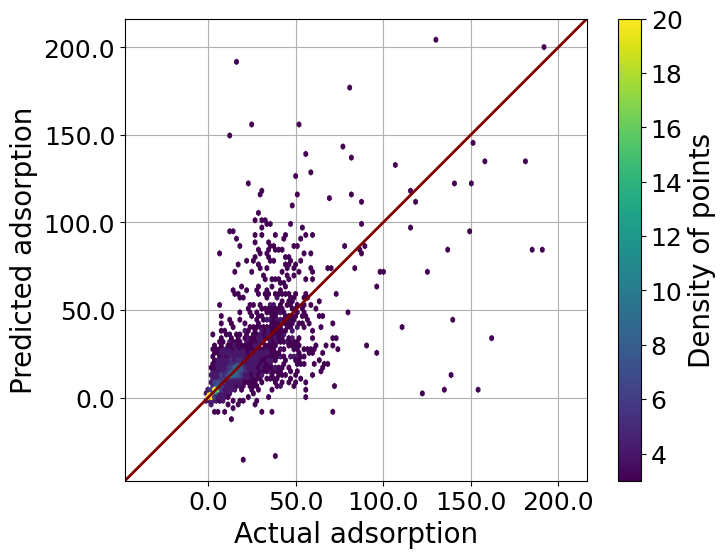

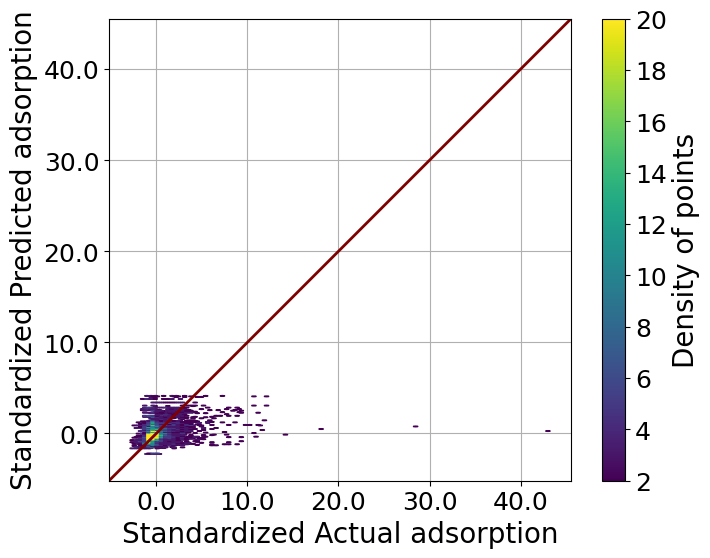

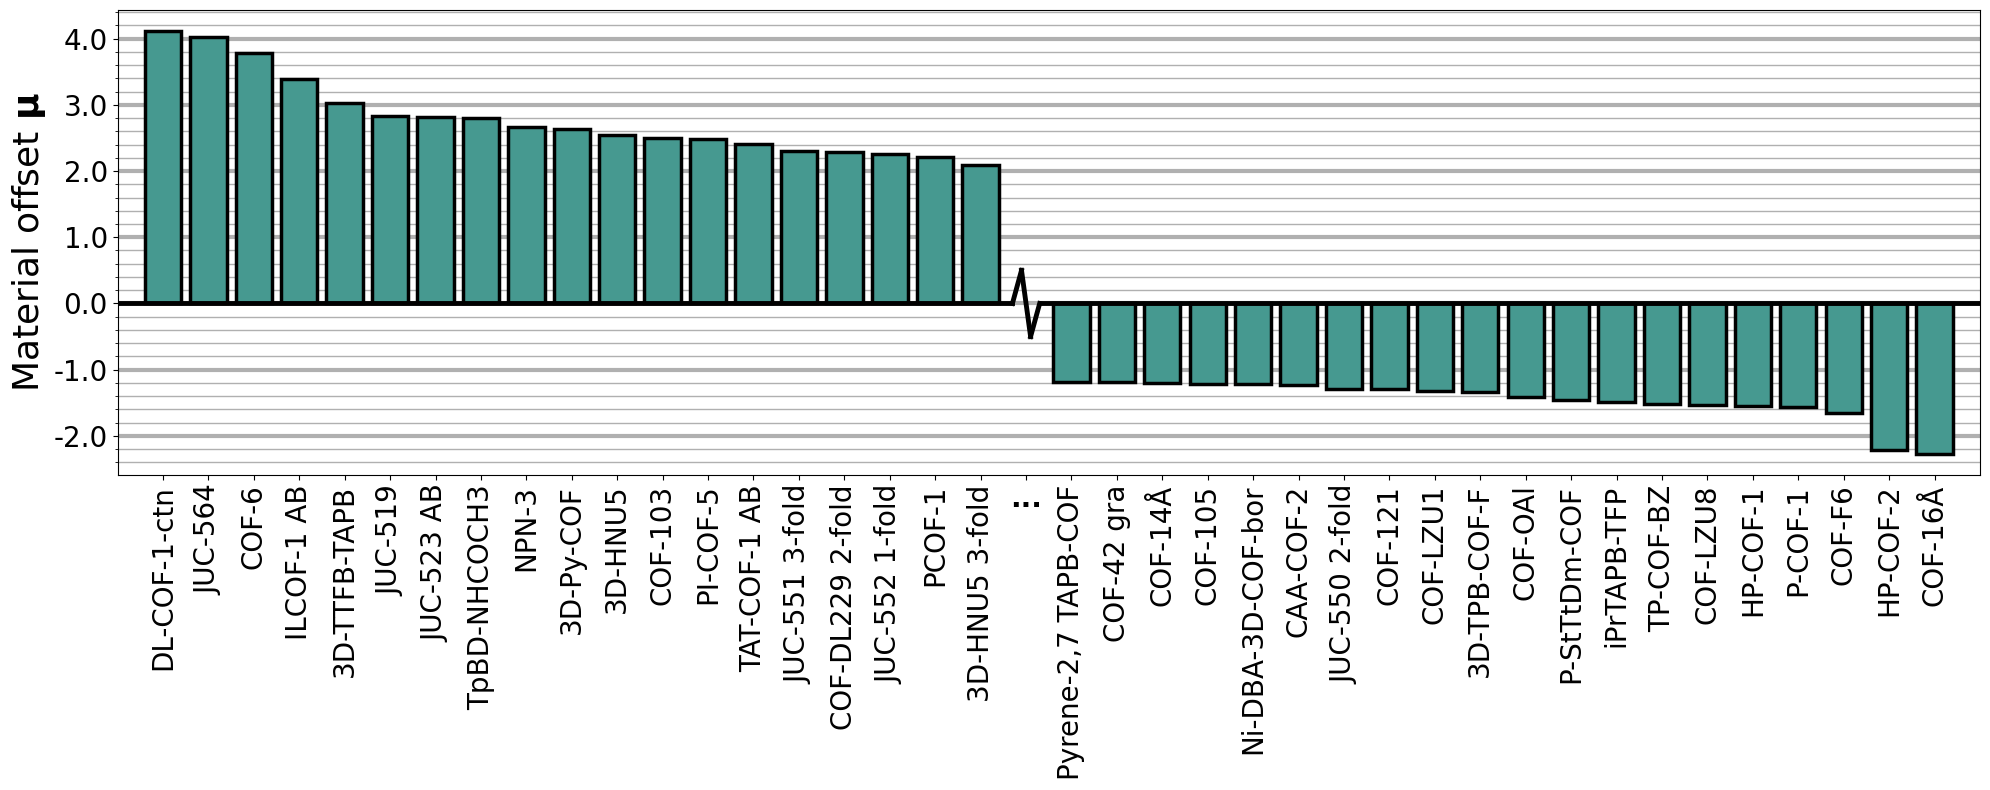

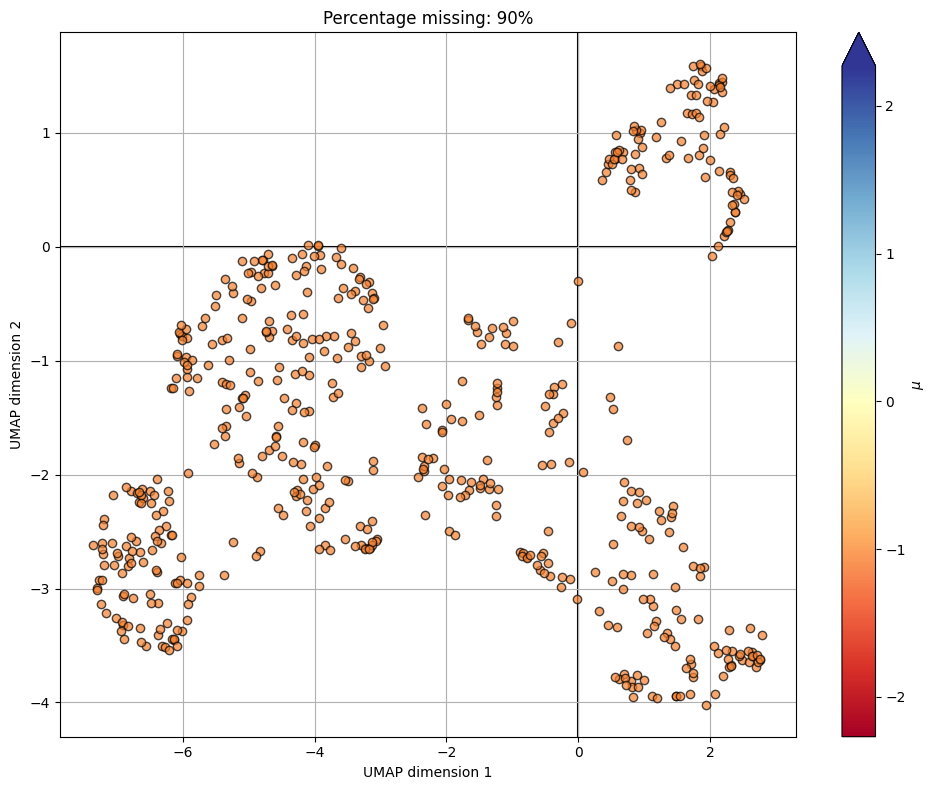

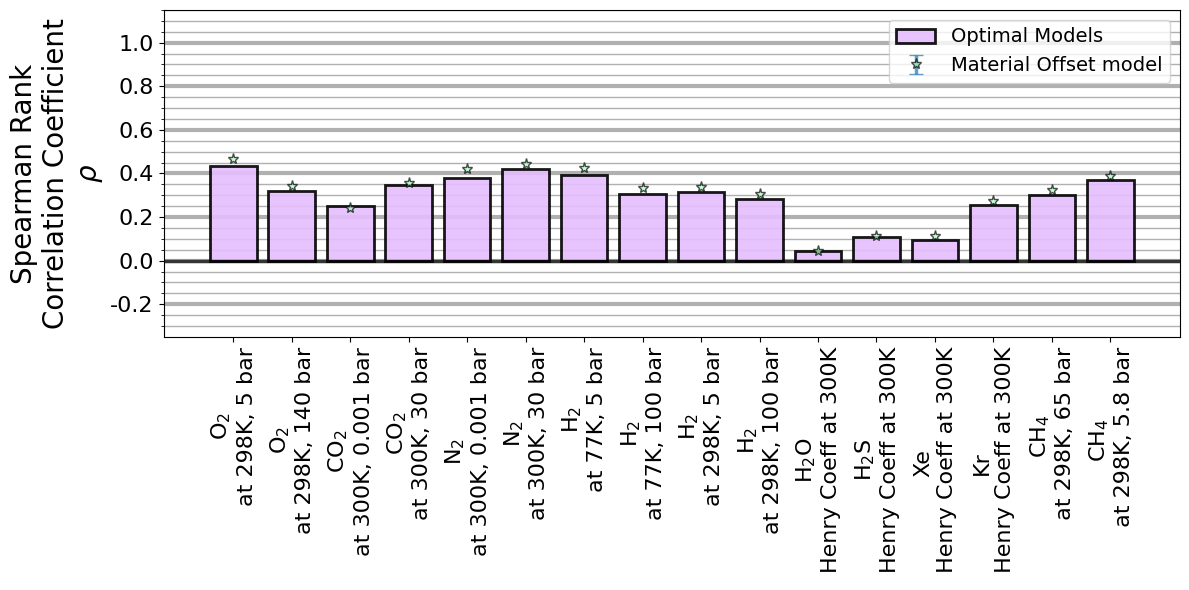

In [26]:
progress_meter = Progress(length(ks) * length(γs) * n_simulations * length(target_sparsities)) # progress meter
#result_df = DataFrame(:opt_k => Int64[], :opt_γ => Float64[], Symbol("target_sparsity") => Float64[], Symbol("sparsity") => [], 
#                      Symbol("test_rmse") => Float64[], Symbol("test_ρ") => Float64[],
#                      Symbol("test_rmse_simple_model") => Float64[], Symbol("test_ρ_simple_model") => Float64[],
#                      Symbol("ρ_ch4") => Float64[], Symbol("ρ_h2sh2o") => Float64[], Symbol("ρ_h2_a") => Float64[],
#                      Symbol("ρ_h2_b") => Float64[], Symbol("ρ_h2_c") => Float64[], Symbol("ρ_o2") => Float64[],
#                      Symbol("ρ_xekr") => Float64[],
#                      Symbol("simple_ρ_ch4") => Float64[], Symbol("simple_ρ_h2sh2o") => Float64[], Symbol("simple_ρ_h2_a") => Float64[],
#                      Symbol("simple_ρ_h2_b") => Float64[], Symbol("simple_ρ_h2_c") => Float64[], Symbol("simple_ρ_o2") => Float64[],
#                      Symbol("simple_ρ_xekr") => Float64[]) 

result_df = DataFrame(:opt_k => Int64[], :opt_γ => Float64[], Symbol("target_sparsity") => Float64[], Symbol("sparsity") => [], 
                      Symbol("test_rmse") => Float64[], Symbol("test_ρ") => Float64[],
                      Symbol("test_rmse_simple_model") => Float64[], Symbol("test_ρ_simple_model") => Float64[],
                      Symbol("ρ_o2_5bar") => Float64[], Symbol("ρ_o2_140bar") => Float64[], Symbol("ρ_co2_0.001bar") => Float64[],
                      Symbol("ρ_co2_30bar") => Float64[], Symbol("ρ_n2_0.001bar") => Float64[], Symbol("ρ_n2_30bar") => Float64[],
                      Symbol("ρ_h2_77K_5bar") => Float64[], Symbol("ρ_h2_77K_100bar") => Float64[], Symbol("ρ_h2_298K_5bar") => Float64[],
                      Symbol("ρ_h2_298K_100bar") => Float64[], Symbol("ρ_h2o") => Float64[], Symbol("ρ_h2s") => Float64[],
                      Symbol("ρ_xe") => Float64[], Symbol("ρ_kr") => Float64[], Symbol("ρ_ch4_65bar") => Float64[],
                      Symbol("ρ_ch4_5.8bar") => Float64[],
                      Symbol("simple_ρ_o2_5bar") => Float64[], Symbol("simple_ρ_o2_140bar") => Float64[], Symbol("simple_ρ_co2_0.001bar") => Float64[],
                      Symbol("simple_ρ_co2_30bar") => Float64[], Symbol("simple_ρ_n2_0.001bar") => Float64[], Symbol("simple_ρ_n2_30bar") => Float64[],
                      Symbol("simple_ρ_h2_77K_5bar") => Float64[], Symbol("simple_ρ_h2_77K_100bar") => Float64[], Symbol("simple_ρ_h2_298K_5bar") => Float64[],
                      Symbol("simple_ρ_h2_298K_100bar") => Float64[], Symbol("simple_ρ_h2o") => Float64[], Symbol("simple_ρ_h2s") => Float64[],
                      Symbol("simple_ρ_xe") => Float64[], Symbol("simple_ρ_kr") => Float64[], Symbol("simple_ρ_ch4_65bar") => Float64[],
                      Symbol("simple_ρ_ch4_5.8bar") => Float64[])

for (i_sparsity, target_sparsity) in enumerate(target_sparsities)
    for (sim, seed) in enumerate(random_seeds)
        sparse_matrix, sparsity = create_sparse_matrix_bernoulli(curated_matrix, target_sparsity, seed=seed)
        means, stdes = standardize_cols!(sparse_matrix)
        sparse_matrix = collect(sparse_matrix')
        all_ids_obs = observations(sparse_matrix) # returns tuple of observations
        nb_obs = length(all_ids_obs)
        shuffle!(all_ids_obs)
        train_ids_obs = all_ids_obs[1:(4*floor(Int, nb_obs/5))]
        valid_ids_obs = all_ids_obs[(4*floor(Int, nb_obs/5) + 1):end]
        @assert length(train_ids_obs) + length(valid_ids_obs) == nb_obs
        @assert length(unique(vcat(train_ids_obs, valid_ids_obs))) == length(unique(all_ids_obs))
        
        valid_rmses = zeros((length(ks), length(γs)))
        valid_ρs = zeros((length(ks), length(γs)))
        for (i_k, k) in enumerate(ks), (i_γ, γ) in enumerate(γs)
            valid_rmses[i_k, i_γ], valid_ρs[i_k, i_γ] = run_simulation(sparse_matrix, train_ids_obs, valid_ids_obs, 
                                                                        k, γ, progress_meter)
        end 
        
        global gloval_rmses = deepcopy(valid_rmses)
        opt_idx = argmin(valid_rmses)
        opt_k = ks[opt_idx[1]]
        opt_γ = γs[opt_idx[2]]
        
        test_ids_obs = [(i, j) for i=1:size(sparse_matrix)[1], j=1:size(sparse_matrix)[2] if !((i,j) in all_ids_obs)][:]
        scaled_curated_matrix = zeros(size(curated_matrix'))
        @assert size(scaled_curated_matrix)[2] == size(curated_matrix)[1]
        for i = 1:size(scaled_curated_matrix)[1]
            scaled_curated_matrix[i,:] .= (curated_matrix[:,i] .- means[i]) ./ stdes[i]
        end
        
        ### Create optimal model for this Sim
        G, M, glrm, ch = fit_glrm(sparse_matrix, opt_k, opt_γ, all_ids_obs, verbose=false)
        Â = impute(glrm) # predictions
        test_pred = [Â[i,j] for (i,j) in test_ids_obs]
        test_true = [scaled_curated_matrix[i,j] for (i,j) in test_ids_obs]
        test_rmse = rmsd(test_pred, test_true)
        test_ρ = ρ_wt_avg(convert(Array{Union{Float64, Missing}, 2}, collect(curated_matrix')), Â, test_ids_obs)
        
        ### Simple model with k=1 for comparison
        G_simple, M_simple, glrm, ch = fit_glrm(sparse_matrix, 1, 0.0, all_ids_obs, verbose=false)
        Â_simple = impute(glrm) # predictions
        test_pred_simple = [Â_simple[i,j] for (i,j) in test_ids_obs]
        test_true_simple = [scaled_curated_matrix[i,j] for (i,j) in test_ids_obs]
        test_rmse_simple = rmsd(test_pred_simple, test_true_simple)
        test_ρ_simple = ρ_wt_avg(convert(Array{Union{Float64, Missing}, 2}, collect(curated_matrix')), Â_simple, test_ids_obs)
        
        ρ_gs = zeros(global_ng)
        ρ_gs_simple = zeros(global_ng)
        for g = 1:global_ng
            ρ_gs[g] = ρ_g(convert(Array{Union{Float64, Missing}, 2}, scaled_curated_matrix), Â, g, test_ids_obs)[2]
        end
        for g = 1:global_ng
            ρ_gs_simple[g] = ρ_g(convert(Array{Union{Float64, Missing}, 2}, scaled_curated_matrix), Â_simple, g, test_ids_obs)[2]
        end
        
        if sim == 1
            parity_plot(convert(Array{Float64, 2}, Â), collect(curated_matrix'), test_ids_obs, means, stdes, target_sparsity)
            plot_offset(M[end,:], target_sparsity)
            if ~(size(M)[1] == 1)
                if target_sparsity == 0.6
                    global point6M = deepcopy(M[1:end-1,:])
                    global point6G = deepcopy(G[1:end-1,:])
                end
                plot_latent_space(M[1:end-1,:], G[1:end-1,:], M[end,:], target_sparsity)
            end
        end
        
        ProgressMeter.next!(progress_meter)
        temp_results = [opt_k, opt_γ, target_sparsity, sparsity, test_rmse, test_ρ, test_rmse_simple, test_ρ_simple,
                        ρ_gs..., ρ_gs_simple...]
        push!(result_df, temp_results)
    end
    spearman_ranks = convert(Array{Float64, 2}, result_df[result_df[!, :target_sparsity] .== target_sparsity, [Symbol("ρ_o2_5bar"), Symbol("ρ_o2_140bar"), Symbol("ρ_co2_0.001bar"),
                      Symbol("ρ_co2_30bar"), Symbol("ρ_n2_0.001bar"), Symbol("ρ_n2_30bar"), Symbol("ρ_h2_77K_5bar"), Symbol("ρ_h2_77K_100bar"), 
                      Symbol("ρ_h2_298K_5bar"), Symbol("ρ_h2_298K_100bar"), Symbol("ρ_h2o"), Symbol("ρ_h2s"), Symbol("ρ_xe"), 
                      Symbol("ρ_kr"), Symbol("ρ_ch4_65bar"), Symbol("ρ_ch4_5.8bar")]])
    spearman_ranks_simple = convert(Array{Float64, 2}, result_df[result_df[!, :target_sparsity] .== target_sparsity, [Symbol("simple_ρ_o2_5bar"), Symbol("simple_ρ_o2_140bar"), Symbol("simple_ρ_co2_0.001bar"),
                              Symbol("simple_ρ_co2_30bar"), Symbol("simple_ρ_n2_0.001bar"), Symbol("simple_ρ_n2_30bar"), Symbol("simple_ρ_h2_77K_5bar"), Symbol("simple_ρ_h2_77K_100bar"), 
                              Symbol("simple_ρ_h2_298K_5bar"), Symbol("simple_ρ_h2_298K_100bar"), Symbol("simple_ρ_h2o"), Symbol("simple_ρ_h2s"), Symbol("simple_ρ_xe"), 
                              Symbol("simple_ρ_kr"), Symbol("simple_ρ_ch4_65bar"), Symbol("simple_ρ_ch4_5.8bar")]])
    
   # spearman_ranks = convert(Array{Float64, 2}, result_df[result_df[!, :target_sparsity] .== target_sparsity, [Symbol("ρ_ch4"), 
   #                   Symbol("ρ_h2sh2o"), Symbol("ρ_h2_a"), Symbol("ρ_h2_b"), Symbol("ρ_h2_c"), Symbol("ρ_o2"), Symbol("ρ_xekr")]])
   #             
   # spearman_ranks_simple = convert(Array{Float64, 2}, result_df[result_df[!, :target_sparsity] .== target_sparsity, [Symbol("simple_ρ_ch4"), Symbol("simple_ρ_h2sh2o"), Symbol("simple_ρ_h2_a"),
   #                   Symbol("simple_ρ_h2_b"), Symbol("simple_ρ_h2_c"), Symbol("simple_ρ_o2"),
   #                   Symbol("simple_ρ_xekr")]]) 
    spearman_plot(mean(spearman_ranks, dims=1)[:],std(spearman_ranks, dims=1)[:], mean(spearman_ranks_simple, dims=1)[:], std(spearman_ranks_simple, dims=1)[:], target_sparsity)
    
end

In [27]:
show(result_df, allcols=true, allrows=false)

1×40 DataFrame
│ Row │ opt_k │ opt_γ   │ target_sparsity │ sparsity │ test_rmse │ test_ρ   │
│     │ Int64 │ Float64 │ Float64         │ Any      │ Float64   │ Float64  │
├─────┼───────┼─────────┼─────────────────┼──────────┼───────────┼──────────┤
│ 1   │ 6     │ 100.0   │ 0.9             │ 0.900223 │ 1.43465   │ 0.288909 │

│ Row │ test_rmse_simple_model │ test_ρ_simple_model │ ρ_o2_5bar │ ρ_o2_140bar │
│     │ Float64                │ Float64             │ Float64   │ Float64     │
├─────┼────────────────────────┼─────────────────────┼───────────┼─────────────┤
│ 1   │ 1.44154                │ 0.308646            │ 0.432994  │ 0.320409    │

│ Row │ ρ_co2_0.001bar │ ρ_co2_30bar │ ρ_n2_0.001bar │ ρ_n2_30bar │
│     │ Float64        │ Float64     │ Float64       │ Float64    │
├─────┼────────────────┼─────────────┼───────────────┼────────────┤
│ 1   │ 0.249571       │ 0.347674    │ 0.379766      │ 0.419022   │

│ Row │ ρ_h2_77K_5bar │ ρ_h2_77K_100bar │ ρ_h2_298K_5bar │ ρ_h2_298K_100ba

In [28]:
CSV.write("result_df.csv", result_df)

"result_df.csv"

In [29]:
new_title_dict = Dict("o2_5bar" => L"O$_2$" * @sprintf("\nat 298K,\n5 bar"), "o2_140bar" => L"O$_2$" * @sprintf("\nat 298K,\n140 bar"), "co2_0.001bar" => L"CO$_2$" * @sprintf("\nat 300K,\n0.001 bar"), 
                  "co2_30bar" => L"CO$_2$" * @sprintf("\nat 300K,\n30 bar"), "n2_0.001bar" => L"N$_2$" * @sprintf("\nat 300K,\n0.001 bar"), 
                  "n2_30bar" => L"N$_2$" * @sprintf("\nat 300K,\n30 bar"), "h2_77K_5bar" => L"H$_2$" * @sprintf("\nat 77K,\n5 bar"), 
                  "h2_77K_100bar" => L"H$_2$" * @sprintf("\nat 77K,\n100 bar"), "h2_298K_5bar" => L"H$_2$" * @sprintf("\nat 298K,\n5 bar"), 
                  "h2_298K_100bar" => L"H$_2$" * @sprintf("\nat 298K,\n100 bar"), "h2o_henry" => L"H$_2$O" * @sprintf("\nHenry Coeff\nat 300K"), 
                  "h2s_henry" => L"H$_2$S" * @sprintf("\nHenry Coeff\nat 300K"), "xe_henry" => @sprintf("Xe\n Henry Coeff\nat 300K"), 
                  "kr_henry" => @sprintf("Kr\n Henry Coeff\nat 300K"), "ch4_65bar" => L"CH$_4$" * @sprintf("\n at 298K,\n65 bar"), "ch4_5.8bar" => L"CH$_4$" * @sprintf("\n at 298K,\n5.8 bar"))

Dict{String,String} with 16 entries:
  "h2_298K_100bar" => "H\$_2\$\nat 298K,\n100 bar"
  "o2_5bar"        => "O\$_2\$\nat 298K,\n5 bar"
  "kr_henry"       => "Kr\n Henry Coeff\nat 300K"
  "n2_30bar"       => "N\$_2\$\nat 300K,\n30 bar"
  "n2_0.001bar"    => "N\$_2\$\nat 300K,\n0.001 bar"
  "ch4_65bar"      => "CH\$_4\$\n at 298K,\n65 bar"
  "xe_henry"       => "Xe\n Henry Coeff\nat 300K"
  "ch4_5.8bar"     => "CH\$_4\$\n at 298K,\n5.8 bar"
  "co2_0.001bar"   => "CO\$_2\$\nat 300K,\n0.001 bar"
  "h2_77K_5bar"    => "H\$_2\$\nat 77K,\n5 bar"
  "co2_30bar"      => "CO\$_2\$\nat 300K,\n30 bar"
  "h2o_henry"      => "H\$_2\$O\nHenry Coeff\nat 300K"
  "h2_298K_5bar"   => "H\$_2\$\nat 298K,\n5 bar"
  "h2_77K_100bar"  => "H\$_2\$\nat 77K,\n100 bar"
  "o2_140bar"      => "O\$_2\$\nat 298K,\n140 bar"
  "h2s_henry"      => "H\$_2\$S\nHenry Coeff\nat 300K"

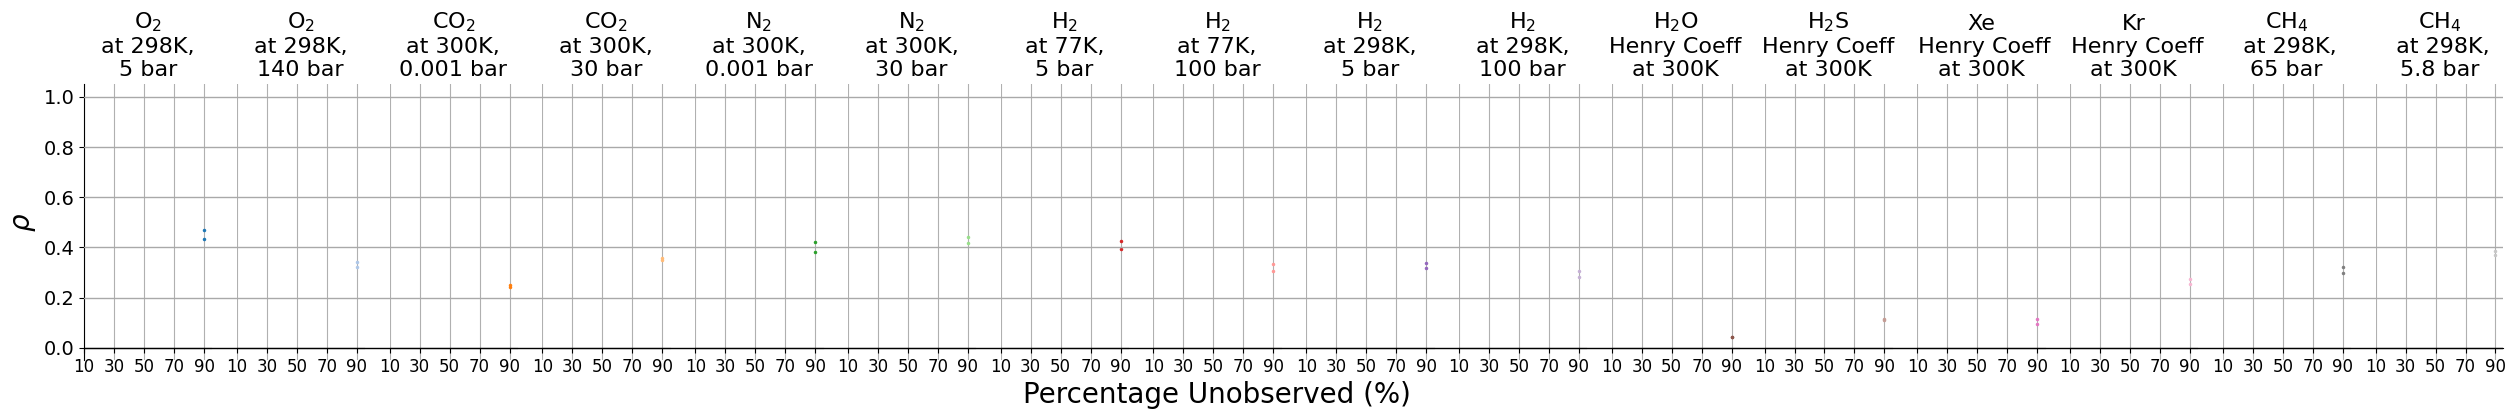

In [30]:
colors = seaborn.color_palette("tab20", length(gases)) # 10 unique "evenly spaced" colors

cols = [Symbol("ρ_o2_5bar"), Symbol("ρ_o2_140bar"), Symbol("ρ_co2_0.001bar"), Symbol("ρ_co2_30bar"), Symbol("ρ_n2_0.001bar"), Symbol("ρ_n2_30bar"),
        Symbol("ρ_h2_77K_5bar"), Symbol("ρ_h2_77K_100bar"), Symbol("ρ_h2_298K_5bar"), Symbol("ρ_h2_298K_100bar"), Symbol("ρ_h2o"), Symbol("ρ_h2s"),
        Symbol("ρ_xe"), Symbol("ρ_kr"), Symbol("ρ_ch4_65bar"), Symbol("ρ_ch4_5.8bar")]
simple_cols = [Symbol("simple_ρ_o2_5bar"), Symbol("simple_ρ_o2_140bar"), Symbol("simple_ρ_co2_0.001bar"), Symbol("simple_ρ_co2_30bar"), Symbol("simple_ρ_n2_0.001bar"), 
               Symbol("simple_ρ_n2_30bar"), Symbol("simple_ρ_h2_77K_5bar"), Symbol("simple_ρ_h2_77K_100bar"), Symbol("simple_ρ_h2_298K_5bar"),
               Symbol("simple_ρ_h2_298K_100bar"), Symbol("simple_ρ_h2o"), Symbol("simple_ρ_h2s"), Symbol("simple_ρ_xe"), Symbol("simple_ρ_kr"), 
               Symbol("simple_ρ_ch4_65bar"), Symbol("simple_ρ_ch4_5.8bar")]

fig, axs = plt.subplots(ncols=length(gases), figsize=(25,4), gridspec_kw=Dict("hspace" => 0.25))
for (i, ax) in enumerate(axs)
    if i == 1
        ax.set_ylabel(L"\rho", fontsize=20)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(ax.get_yticks(), fontsize=14)
    else
        ax.spines["left"].set_visible(false)
        ax.yaxis.set_visible(false)
    end
    if i == 8
        ax.set_xlabel("Percentage Unobserved (%)", fontsize=20)
    end
    ax.spines["right"].set_visible(false)
    ax.spines["bottom"].set_position("zero")
    ax.spines["top"].set_visible(false)
    ax.set_ylim([-0.05, 1.05])
    ## Optimal model
    gas_avg_ρ_sparsities = [mean(result_df[result_df[!, :target_sparsity] .== sp, :][!, cols[i]]) for sp in target_sparsities]
    gas_std_ρ_sparsities = [std(result_df[result_df[!, :target_sparsity] .== sp, :][!, cols[i]]) for sp in target_sparsities]
#    gas_avg_ρ_sparsities = [all_avg_ρ_gs[j][i] for j = 1:length(target_sparsities)]
#    gas_std_ρ_sparsities = [all_std_ρ_gs[j][i] for j = 1:length(target_sparsities)]
    ax.plot(target_sparsities .* 100, gas_avg_ρ_sparsities, color=colors[i], marker="o", lw=2.5, markersize=1.5)
    above_std = gas_avg_ρ_sparsities .+ gas_std_ρ_sparsities
    below_std = gas_avg_ρ_sparsities .- gas_std_ρ_sparsities
    ax.fill_between(target_sparsities .* 100, above_std, below_std, color=colors[i], alpha=.5, zorder=0.5)
    ## Simplistic model
    gas_avg_ρ_sparsities_simplistic = [mean(result_df[result_df[!, :target_sparsity] .== sp, :][!, simple_cols[i]]) for sp in target_sparsities]
    gas_std_ρ_sparsities_simplistic = [std(result_df[result_df[!, :target_sparsity] .== sp, :][!, simple_cols[i]]) for sp in target_sparsities]
#    gas_avg_ρ_sparsities_simplistic = [all_avg_ρ_gs_simplistic[j][i] for j = 1:length(target_sparsities)]
#    gas_std_ρ_sparsities_simplistic = [all_std_ρ_gs_simplistic[j][i] for j = 1:length(target_sparsities)]
    ax.plot(target_sparsities .* 100, gas_avg_ρ_sparsities_simplistic, color=colors[i], marker="o", linestyle="--", lw=2.5, markersize=1.5)
    above_std_simplistic = gas_avg_ρ_sparsities_simplistic .+ gas_std_ρ_sparsities_simplistic
    below_std_simplistic = gas_avg_ρ_sparsities_simplistic .- gas_std_ρ_sparsities_simplistic
    ax.fill_between(target_sparsities .* 100, above_std_simplistic, below_std_simplistic, color=colors[i], alpha=.5, zorder=0.5)
    ax.set_title(new_title_dict[gases[i]], fontsize=16)
    #ax.set_title(gases[i], fontsize=10)
    ax.set_xticks([10, 30, 50, 70, 90])
    ax.set_xticklabels(ax.get_xticks(), fontsize=12)
    ax.xaxis.grid("on")
    ax.set_axisbelow(true)
end
    
new_ax = fig.add_subplot(111)
xlim = new_ax.get_xlim()
new_ax.plot(xlim, [0, 0], lw=1.0, c="k")
new_ax.set_xlim(xlim)
for a in [0.2, 0.4, 0.6, 0.8, 1.0]
    new_ax.plot(xlim, [a, a], color="#a9a9a9", lw=1.0, zorder=0.1)
end
new_ax.set_ylim([-0.05, 1.05])
new_ax.spines["right"].set_visible(false)
new_ax.spines["top"].set_visible(false)
new_ax.xaxis.set_visible(false)
new_ax.yaxis.set_visible(false)
new_ax.axis("off")
fig.subplots_adjust(left = 0.03, right=0.9975, top=0.8)
#plt.tight_layout()

#fig.text(0.5, -0.04, "Sparsity", ha="center", size=20)
plt.savefig("flex.pdf", dpi=300, format="pdf")

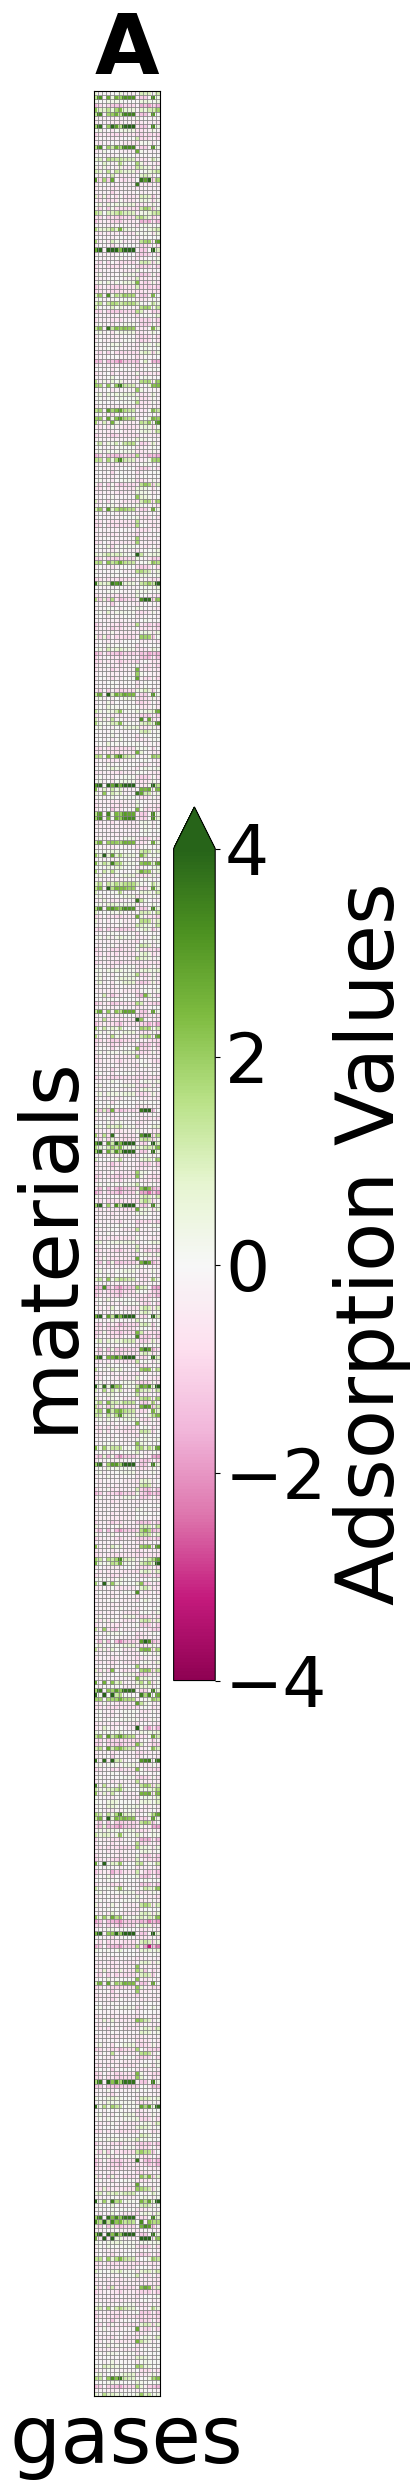

In [31]:
function visualize_matrix(matrix::Union{Array{Float64, 2}, Array{Union{Float64, Missing}, 2}}; figsize::Tuple{Int, Int}=(8,26), 
                          vlim::Union{Float64, Missing}=missing, filename::AbstractString="matrix_viz.png")
    fig, ax = plt.subplots(figsize=figsize)
    nm, ng = size(matrix)
    spy_matrix = deepcopy(matrix)
    spy_matrix[ismissing.(matrix)] .= 0.0
    vlim = ismissing(vlim) ? maximum(abs.(spy_matrix)) : vlim
    extend_bot = -vlim > minimum(spy_matrix)
    extend_top = vlim < maximum(spy_matrix)
    extend = "neither"
    if extend_bot && extend_top
        extend = "both"
    elseif extend_bot && !extend_top
        extend = "min"
    elseif extend_top && !extend_bot
        extend = "max"
    end

    spy_matrix2 = fill(0.0, size(matrix))
    spy_matrix2[.!ismissing.(matrix)] .= 0
    spy_matrix2[ismissing.(matrix)] .= 1

    img = ax.pcolormesh(spy_matrix, cmap="PiYG", 
        vmax=vlim, vmin=-vlim)

    cbar = colorbar(img, label="Adsorption Values", shrink=0.6, extend=extend)
    cbar.set_label("Adsorption Values", size=58)
    cbar.ax.tick_params(labelsize=50) 
    #cmap = plt.get_cmap("PiYG")
    #colors = cmap(collect(1:cmap.N))
    colors = Array{Float64, 2}(undef, 2, 4)
    colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
    colors[2, :] .= [192., 192., 192., 255.] ./ 255
    cmap = matplotlib.colors.ListedColormap(colors)
    img = ax.pcolormesh(spy_matrix2, cmap=cmap)

    # grid lines
    for x = 1:nm
        ax.plot([0, ng], [x, x], linewidth=0.55, color="gray")
    end
    for y = 1:ng
        ax.plot([y, y], [0, nm], linewidth=0.55, color="gray")
    end
    ax.set_aspect("equal")
    ax.set_title(L"\mathbf{A}", fontsize=60)
    ax.set_xlabel("gases", fontsize=58)
    ax.set_ylabel("materials", fontsize=58)
    # TODO make missing values black to distinguish between actual 0 and missing.
    # TODO xticks, yticks with material and gas names
    ax.set_xticks([])
    ax.set_yticks([])
#    ax.set_xticks(collect(1:global_ng) .- .5)
#    ax.set_xticklabels(gases, rotation=90, fontsize=12)
    #yticks(collect(1:nm) .- 0.5, materials, fontsize=12);
    #plt.tight_layout()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, format="pdf")
end
#visualize_matrix(curated_matrix)  
temp_matrix = deepcopy(curated_matrix)
standardize_cols!(temp_matrix)
visualize_matrix(temp_matrix, vlim=4.0, figsize=(5,25), filename="standardized_matrix_viz.pdf")  

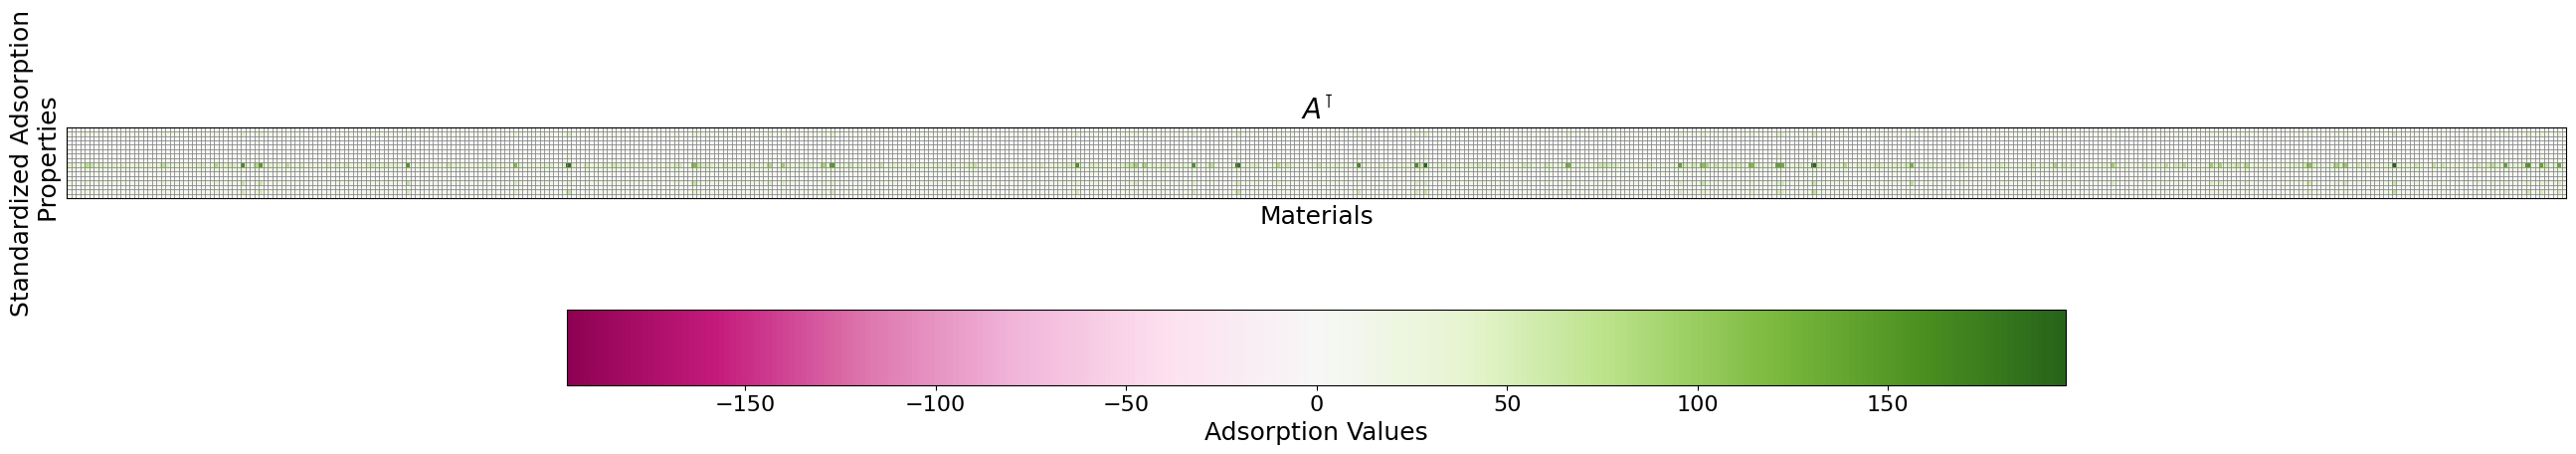

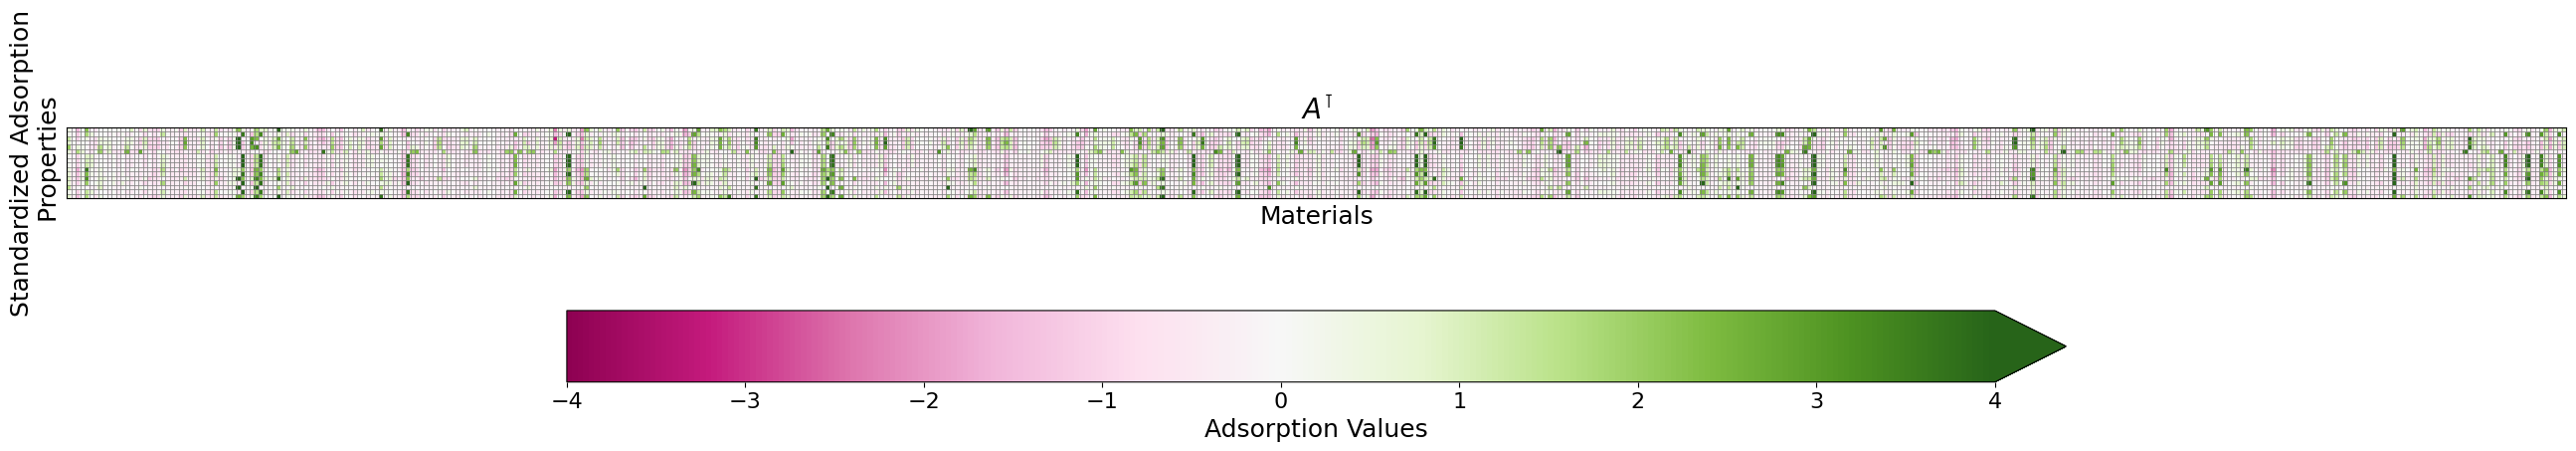

In [32]:
function visualize_transposed_matrix(matrix::Union{Array{Float64, 2}, Array{Union{Float64, Missing}, 2}}; figsize::Tuple{Int, Int}=(26,8), 
                          vlim::Union{Float64, Missing}=missing, filename::AbstractString="transposed_matrix_viz.png")
    fig, ax = plt.subplots(figsize=figsize)
    ng, nm = size(matrix)
    spy_matrix = deepcopy(matrix)
    spy_matrix[ismissing.(matrix)] .= 0.0
    vlim = ismissing(vlim) ? maximum(abs.(spy_matrix)) : vlim
    extend_bot = -vlim > minimum(spy_matrix)
    extend_top = vlim < maximum(spy_matrix)
    extend = "neither"
    if extend_bot && extend_top
        extend = "both"
    elseif extend_bot && !extend_top
        extend = "min"
    elseif extend_top && !extend_bot
        extend = "max"
    end

    spy_matrix2 = fill(0.0, size(matrix))
    spy_matrix2[.!ismissing.(matrix)] .= 0
    spy_matrix2[ismissing.(matrix)] .= 1

    img = ax.pcolormesh(spy_matrix, cmap="PiYG", 
        vmax=vlim, vmin=-vlim)
    cbar = colorbar(img, shrink=0.6, extend=extend, orientation="horizontal")
    cbar.set_label("Adsorption Values", fontsize=18)
    cbar.ax.tick_params(labelsize=16) 

    #cmap = plt.get_cmap("PiYG")
    #colors = cmap(collect(1:cmap.N))
    colors = Array{Float64, 2}(undef, 2, 4)
    colors[1, :] .= [255.0, 255.0, 255.0, 0.0] ./ 255
    colors[2, :] .= [192., 192., 192., 255.] ./ 255
    cmap = matplotlib.colors.ListedColormap(colors)
    img = ax.pcolormesh(spy_matrix2, cmap=cmap)

    # grid lines
    for x = 1:ng
        plot([0, nm], [x, x], linewidth=0.55, color="gray")
    end
    for y = 1:nm
        plot([y, y], [0, ng], linewidth=0.55, color="gray")
    end
    ax.set_aspect("equal")
    ax.set_title(L"A^{\intercal}", fontsize=20)
    ax.set_xlabel("Materials", fontsize=18)
    # TODO make missing values black to distinguish between actual 0 and missing.
    # TODO xticks, yticks with material and gas names
    #ax.set_yticks(collect(1:global_ng) .- .5)
    #ax.set_yticklabels(gases, fontsize=12)
    ax.set_yticks([])
    ax.set_ylabel(@sprintf("Standardized Adsorption\n Properties"), fontsize=18)
    ax.set_xticks([])
    plt.tight_layout()
    #yticks(collect(1:nm) .- 0.5, materials, fontsize=12);
    plt.tight_layout()
    plt.savefig(filename, dpi=300, format="png")
end
visualize_transposed_matrix(collect(curated_matrix'))
temp_matrix = deepcopy(curated_matrix)
standardize_cols!(temp_matrix)
visualize_transposed_matrix(collect(temp_matrix'), vlim=4.0, filename="transposed_standardized_matrix_viz.png")  

In [33]:
latspace = plot_latent_space(point6M[1:end-1,:], point6G[1:end-1,:], point6M[end,:], 0.6)
P_latent_space = umap(point6G[1:end-1,:], 2; n_neighbors=3, min_dist=0.1)

UndefVarError: UndefVarError: point6M not defined

In [34]:
zeopp = CSV.read("zeopp_results.csv")
new_cof_names = [split(x, ".json")[1] * ".cif" for x in zeopp[!, :cof]]
zeopp[!, :cof] .= new_cof_names

curated_df_and_zeopp = og_df[!, Symbol.(["cof", "o2_5bar", "o2_140bar", "co2_0.001bar", "co2_30bar", "n2_0.001bar", "n2_30bar", 
                       "h2_77K_5bar", "h2_77K_100bar", "h2_298K_5bar", "h2_298K_100bar", "h2o_henry", "h2s_henry",
                       "xe_henry", "kr_henry", "ch4_65bar", "ch4_5.8bar"])]
curated_df_and_zeopp[!, Symbol("h2o_henry")] = log10.(1e5 .* curated_df_and_zeopp[!, Symbol("h2o_henry")]) # Converting units from mol/(kg-Pa) to mol/(kg-bar)
curated_df_and_zeopp[!, Symbol("h2s_henry")] = log10.(1e5 .* curated_df_and_zeopp[!, Symbol("h2s_henry")]) #   1 Pa = 1e-5 bar 
curated_df_and_zeopp[!, Symbol("xe_henry")] = log10.(1e5 .* curated_df_and_zeopp[!, Symbol("xe_henry")])   #   Then taking the log10 of the Henry Coeffs to spread
curated_df_and_zeopp[!, Symbol("kr_henry")] = log10.(1e5 .* curated_df_and_zeopp[!, Symbol("kr_henry")]);   #   their range more, so they won't group up around 0


┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read(::String) at CSV.jl:40
└ @ CSV /home/sturlusa/.julia/packages/CSV/MKemC/src/CSV.jl:40


In [35]:
curated_df_and_zeopp = innerjoin(curated_df_and_zeopp, zeopp, on=:cof)
colormaps = [PyPlot.matplotlib.cm.Greens,
             PyPlot.matplotlib.cm.Purples,
             PyPlot.matplotlib.cm.Blues,
             PyPlot.matplotlib.cm.Oranges,
             PyPlot.matplotlib.cm.Reds,
             PyPlot.matplotlib.cm.YlOrBr,
             PyPlot.matplotlib.cm.YlOrRd,
             PyPlot.matplotlib.cm.OrRd,
             PyPlot.matplotlib.cm.PuRd,
             PyPlot.matplotlib.cm.RdPu,
             PyPlot.matplotlib.cm.BuPu,
             PyPlot.matplotlib.cm.GnBu,
             PyPlot.matplotlib.cm.PuBu,
             PyPlot.matplotlib.cm.YlGnBu,
             PyPlot.matplotlib.cm.PuBuGn,
             PyPlot.matplotlib.cm.BuGn,
             PyPlot.matplotlib.cm.YlGn,
             PyPlot.matplotlib.cm.spring,
             PyPlot.matplotlib.cm.Oranges,
             PyPlot.matplotlib.cm.Greens,
             PyPlot.matplotlib.cm.Blues,
             PyPlot.matplotlib.cm.Wistia,
             PyPlot.matplotlib.cm.cool]

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(P_latent_space[1,:], P_latent_space[2,:], ec="k", fc="#bfef45", linewidth=1.5, alpha=0.8)
ax.grid("on")
ax.set_axisbelow(true)

texts = []
for i = 1:global_ng
    push!(texts, plt.annotate(title_dict[gases[i]], (P_latent_space[1, i], P_latent_space[2, i]), color="black", fontsize=8))
end

adjustText.adjust_text(texts, force_text=(0.01,0.01))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot(xlim, [0,0], c="#000000", zorder=0.5, lw=2.5)
ax.plot([0,0], ylim, c="#000000", zorder=0.5, lw=2.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("UMAP dimension 1", fontsize=18)
ax.set_ylabel("UMAP dimension 2", fontsize=18)
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
plt.tight_layout()
plt.savefig("Platent_space.pdf", dpi=300, format="pdf")

UndefVarError: UndefVarError: P_latent_space not defined

In [37]:
names(curated_df_and_zeopp)

22-element Array{String,1}:
 "cof"
 "o2_5bar"
 "o2_140bar"
 "co2_0.001bar"
 "co2_30bar"
 "n2_0.001bar"
 "n2_30bar"
 "h2_77K_5bar"
 "h2_77K_100bar"
 "h2_298K_5bar"
 "h2_298K_100bar"
 "h2o_henry"
 "h2s_henry"
 "xe_henry"
 "kr_henry"
 "ch4_65bar"
 "ch4_5.8bar"
 "largest_free_sphere"
 "largest_included_sphere"
 "largest_included_free_sphere"
 "AV_volume_fraction"
 "ASA_m^2/cm^3"

In [38]:
for (i, name) in enumerate(names(curated_df_and_zeopp))
    if name == "cof"
        continue
    end
    fig, ax = plt.subplots(figsize=(8,6))
    cmap = colormaps[i]
    normalized_list = (curated_df_and_zeopp[!, name] .- mean(curated_df_and_zeopp[!, name])) ./ std(curated_df_and_zeopp[!, name])
    extend_string = "neither"
    if name != "co2_0.001bar"
        norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(curated_df_and_zeopp[!, name]), vmax=maximum((curated_df_and_zeopp[!, name])))
    else
        norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(curated_df_and_zeopp[!, name]), vmax=0.02)
        extend_string = "max"
    end
#    norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(normalized_list), vmax=maximum((normalized_list)))
    name_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax.scatter(latspace[1,:], latspace[2,:], ec="k", c=curated_df_and_zeopp[!, name], linewidth=1.5, cmap=cmap, norm=norm, alpha=0.8)
#    ax.scatter(latspace[1,:], latspace[2,:], ec="k", c=normalized_list, linewidth=1.5, cmap=cmap, norm=norm, alpha=0.8)
    ax.grid("on")
    ax.set_axisbelow(true)
            
#    texts = []
#    for i = 1:global_ng
#        push!(texts, plt.annotate(gases[i], (latent_space[1, global_nm+i], latent_space[2, global_nm+i]), color="red"))
#    end

#    adjustText.adjust_text(texts, force_text=(0.01,0.01))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, [0,0], c="#000000", zorder=0.5, lw=2.5)
    ax.plot([0,0], ylim, c="#000000", zorder=0.5, lw=2.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("UMAP dimension 1", fontsize=18)
    ax.set_ylabel("UMAP dimension 2", fontsize=18)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
#    ax.set_title(@sprintf("Percentage missing: %d%%", 60), fontsize=14)
    cbar = plt.colorbar(name_to_color, ax=ax, extend=extend_string)
    for t in cbar.ax.get_yticklabels()
        t.set_fontsize(16)
    end
    cbar.set_label(title_dict[name], fontsize=18)
    plt.tight_layout()
    if name == "ASA_m^2/cm^3"
        plt.savefig("latent_space_asa_m2cm3.pdf", dpi=300, format="pdf")
    else
        plt.savefig("latent_space_" * name * ".pdf", dpi=300, format="pdf")
    end
end

UndefVarError: UndefVarError: latspace not defined

In [39]:
materials[latspace[1,:] .> 4]

UndefVarError: UndefVarError: latspace not defined

In [40]:
[cif_file_dict[split(mat, ".")[1]] for mat in materials[latspace[1,:] .> 4]]

UndefVarError: UndefVarError: latspace not defined

In [41]:
cif_file_dict

Dict{String,String} with 626 entries:
  "19361N2" => "TT TAPB-COF"
  "16121N2" => "TpPa-SO3H-Py"
  "20330N2" => "TAPB-PDA"
  "18122N3" => "3D-IL-COF-3"
  "17131N2" => "TP-COF-DAB"
  "19420N3" => "PCOF-1"
  "19412N2" => "Per-Py COF"
  "19191N2" => "CCOF-8"
  "19370N2" => "Aminal-COF-2"
  "16271N2" => "4PE-2P"
  "20112N3" => "JUC-550 3-fold"
  "19352N2" => "BFBAEPy-COF"
  "19440N2" => "CuPc-pz"
  "20111N3" => "JUC-550 2-fold"
  "17061N2" => "HAT-NTBA-COF"
  "16054N2" => "MC-COF-TP-E12E21"
  "05000N2" => "COF-1"
  "20540N2" => "QTD-COF-1"
  "20391N2" => "Py-FTP-BT-COF"
  "16160N2" => "IISERP-COF3"
  "10001N2" => "CTF-2 AB"
  "17160N3" => "3D-CuPor-COF-0P"
  "13190N2" => "CTV-COF-1"
  "12060N2" => "ZnPc-COF"
  "16080N2" => "BW-COF AA"
  ⋮         => ⋮

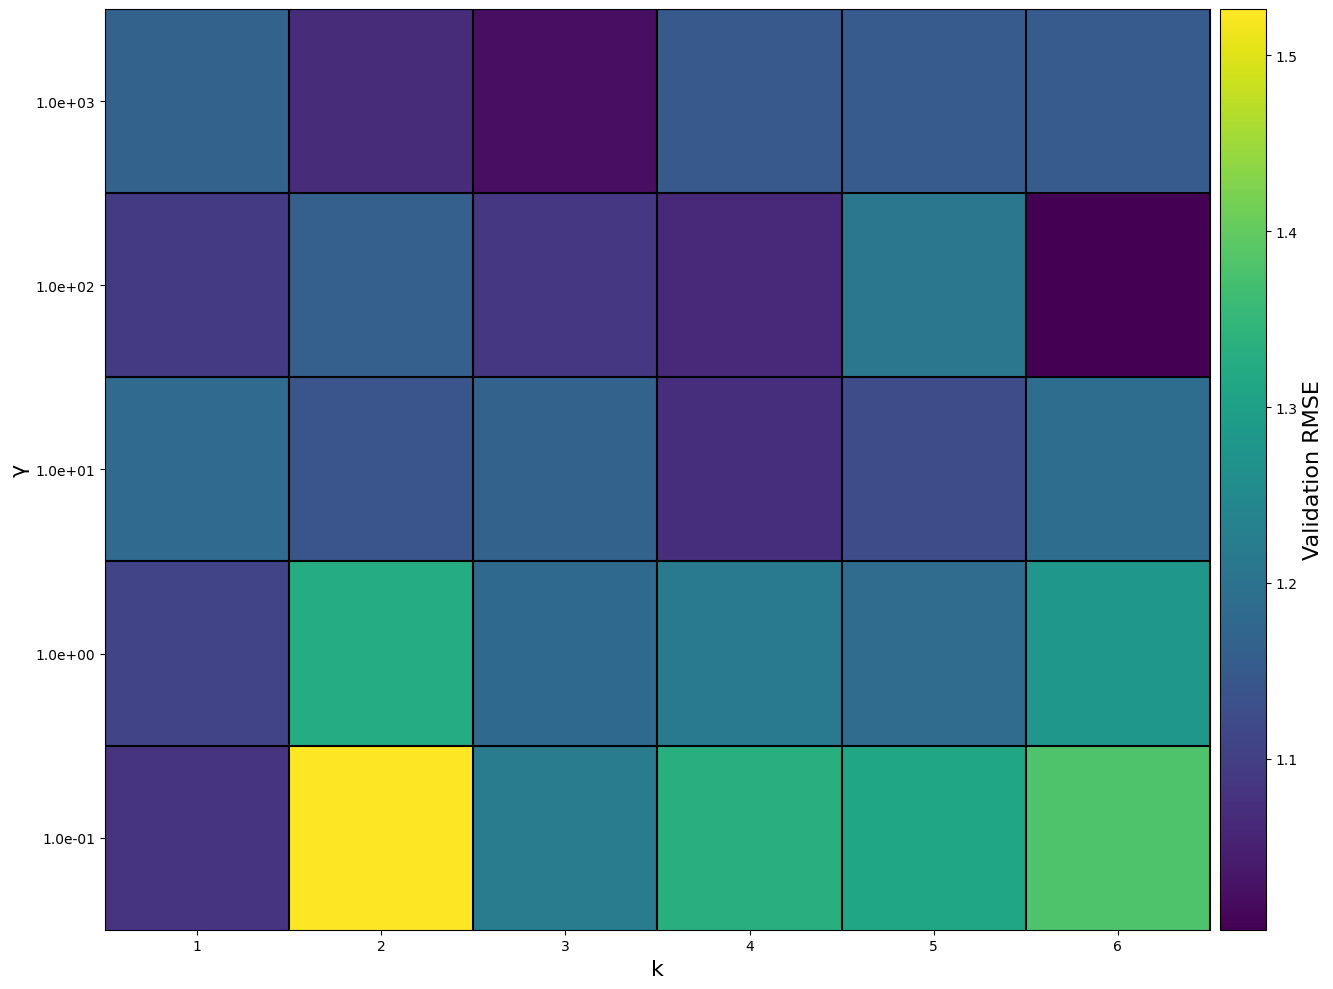

In [42]:
fig, ax = plt.subplots(figsize=(20,10))
pcol = ax.pcolormesh(gloval_rmses')
ax.set_xticks(range(1, stop=length(ks)) .- 0.5)
ax.set_yticks(range(1, stop=length(γs)) .- 0.5)
ax.set_xticklabels(ks)
ax.set_yticklabels([@sprintf("%.1e", gam) for gam in γs])
for x = 1:length(ks)
    ax.plot([x, x], [0, length(γs)], linewidth=1.5, color="k", zorder=1.5)
end
for y = 1:length(γs)
    ax.plot([0, length(ks)], [y, y], linewidth=1.5, color="k", zorder=1.5)
end
ax.set_ylabel("γ", fontsize=16)
ax.set_xlabel("k", fontsize=16)
cbar = plt.colorbar(pcol, pad=0.005)
cbar.set_label("Validation RMSE", fontsize=16)
ax.set_aspect("equal")
plt.tight_layout()
plt.savefig("valid_heatmap_u09.png", dpi=300, format="png")